# Formula One: Predicting The World Champions Of Tomorrow
### Anthony Chen, Ayush Saldhi and Taylor Oglow


# Introduction

Formula 1 represents the highest class of professional open-wheeled single-seater motorsport, popularly known as formula racing. With unparalleled intensity, a Formula 1 World Championship consists of a series of globe-trotting races held on circuits. Ten teams, each consisting of two starting drivers, responsible for developing and maintaining their cars compete to cross the finish line first after completing several predetermined laps.  Points are awarded to the first ten finishers in each race and are accumulated throughout the season. Ultimately, the driver and the team that have accumulated the most points are crowned with the Drivers’ and Constructors’ World Championship.

Over the past decade, only two teams and four drivers have been successful in their pursuit of the world championship. In a sport that thrives on data, this raises concerns regarding the ability to predict the results of a championship. Knowing this, our team set out to try and answer the following question:

**Question**: 
<br> 
*What will the standing for each driver and constructor be in the upcoming 2022 Formula 1 World Championship?*

To answer this question, we used the dataset “Formula 1 World Championship (1950-2021)” created by the Kaggle user Vopani via http://ergast.com/mrd/, which can be found at https://www.kaggle.com/rohanrao/formula-1-world-championship-1950-2020. The data set consists of 14 files, each containing data on a specific aspect of the sport, such as drivers, constructors, circuits, races etc.

# Methods

Having a metric by which we can assess the driver's performance is central to predicting the standings. In Formula 1, there exist numerous metrics by which we can estimate driver performance, including lap times, pit stops, etc. Ultimately, race time is at the heart of being victorious in a race and quite simply is an integral part of the standings. Hence, we utilized **lap times** as the metric in predicting standings for all drivers and constructors. 

## Phase 1: Loading Data

We begin by loading all required libraries:

In [185]:
library(tidyverse)
library(tidymodels)
library(cowplot)
library(RColorBrewer)
library(knitr)

### 1.1 - Reading data set from the web

Beginning the data analysis, we load the data set that has been uploaded to our group project remote repository, at https://github.com/TaylorOglow/Formula_1, named Formula_1 on GitHub:

In [186]:
# Reading data set from GitHub

circuits <- read_csv("https://raw.githubusercontent.com/TaylorOglow/group_project_proposal/main/data_set/circuits.csv")

constructor_results <- read_csv("https://raw.githubusercontent.com/TaylorOglow/group_project_proposal/main/data_set/constructor_results.csv")

constructor_standings <- read_csv("https://raw.githubusercontent.com/TaylorOglow/group_project_proposal/main/data_set/constructor_standings.csv")

constructors <- read_csv("https://raw.githubusercontent.com/TaylorOglow/group_project_proposal/main/data_set/constructors.csv")

driver_standings <- read_csv("https://raw.githubusercontent.com/TaylorOglow/group_project_proposal/main/data_set/driver_standings.csv")

drivers <- read_csv("https://raw.githubusercontent.com/TaylorOglow/group_project_proposal/main/data_set/drivers.csv")

lap_times <- read_csv("https://raw.githubusercontent.com/TaylorOglow/group_project_proposal/main/data_set/lap_times.csv") 

races <- read_csv("https://raw.githubusercontent.com/TaylorOglow/group_project_proposal/main/data_set/races.csv") 

results <- read_csv("https://raw.githubusercontent.com/TaylorOglow/group_project_proposal/main/data_set/results.csv") 

Rows: 79 Columns: 9

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (6): circuitRef, name, location, country, alt, url
dbl (3): circuitId, lat, lng


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 11950 Columns: 5

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): status
dbl (4): constructorResultsId, raceId, constructorId, points


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 12716 Columns: 7

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): positionText
dbl (6): constructorStandingsId, raceId, constructorId, points, position, wins


ℹ Use `spec()` to retrieve the full column specification for this

## Phase 2: Data Wrangling

It is crucial to first wrangle the data for the scope of this project. We start by ensuring the files that mirror the scope of our analysis are tidy, and then wrangle them to extract distinctive data:

### 2.1 - Circuits

We first print out the first few rows of `circuits` below to ensure that it is tidy:

In [187]:
head(circuits)

circuitId,circuitRef,name,location,country,lat,lng,alt,url
<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.84970,144.96800,10,http://en.wikipedia.org/wiki/Melbourne_Grand_Prix_Circuit
2,sepang,Sepang International Circuit,Kuala Lumpur,Malaysia,2.76083,101.73800,18,http://en.wikipedia.org/wiki/Sepang_International_Circuit
3,bahrain,Bahrain International Circuit,Sakhir,Bahrain,26.03250,50.51060,7,http://en.wikipedia.org/wiki/Bahrain_International_Circuit
4,catalunya,Circuit de Barcelona-Catalunya,Montmeló,Spain,41.57000,2.26111,109,http://en.wikipedia.org/wiki/Circuit_de_Barcelona-Catalunya
5,istanbul,Istanbul Park,Istanbul,Turkey,40.95170,29.40500,130,http://en.wikipedia.org/wiki/Istanbul_Park
6,monaco,Circuit de Monaco,Monte-Carlo,Monaco,43.73470,7.42056,7,http://en.wikipedia.org/wiki/Circuit_de_Monaco


*Figure 2.1 - Loaded Circuits dataset*

The upcoming Formula 1 season consists of 22 races that are scheduled to take place across the globe.

By cross-referencing the official Formula 1 Schedule (https://www.formula1.com/en/racing/2022.html) with `location` in `circuits`, we vectorize all scheduled locations and then filter `circuits` using that vector.

> Note: The presence of circuits in Portimão and Istanbul will be explained in Phase 2.4.

In [188]:
# Vector of 2022 GP locations

locations_2022 <- c("Sakhir", "Portimão", "Melbourne", "Imola", "Miami", "Montmeló", "Monte-Carlo", "Baku", "Montreal", "Silverstone", "Spielberg", "Jeddah", 
                "Le Castellet", "Budapest", "Spa", "Zandvoort", "Monza", "Marina Bay", "Suzuka", "Austin", "Mexico City", "São Paulo", "Abu Dhabi", "Istanbul")

# Filtering circuit data set by locations vector 

circuits_2022 <- circuits %>% 
                  filter(location %in% locations_2022) %>%
                  filter(name != "A1-Ring") %>%
                  select(circuitId:alt)

circuits_2022

circuitId,circuitRef,name,location,country,lat,lng,alt
<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
1,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.96800,10
3,bahrain,Bahrain International Circuit,Sakhir,Bahrain,26.0325,50.51060,7
4,catalunya,Circuit de Barcelona-Catalunya,Montmeló,Spain,41.5700,2.26111,109
5,istanbul,Istanbul Park,Istanbul,Turkey,40.9517,29.40500,130
6,monaco,Circuit de Monaco,Monte-Carlo,Monaco,43.7347,7.42056,7
7,villeneuve,Circuit Gilles Villeneuve,Montreal,Canada,45.5000,-73.52280,13
9,silverstone,Silverstone Circuit,Silverstone,UK,52.0786,-1.01694,153
11,hungaroring,Hungaroring,Budapest,Hungary,47.5789,19.24860,264
13,spa,Circuit de Spa-Francorchamps,Spa,Belgium,50.4372,5.97139,401


We now pull the circuit ids into `circuit_ids`. For ease of usage, we separate the identity and location of the selected circuits into`circuit_IDS`.

In [189]:
circuit_ids <- circuits_2022 %>%
                  pull(circuitId)

circuit_ids

circuits_IDS <- circuits_2022 %>%
                  select(circuitId, name, country, location) %>% 
                   arrange(country)

circuits_IDS

[1]  1  3  4  5  6  7  9 11 13 14 15 18 21 22 24 32 34 39 69 70 73 75 77 79

circuitId,name,country,location
<dbl>,<chr>,<chr>,<chr>
1,Albert Park Grand Prix Circuit,Australia,Melbourne
70,Red Bull Ring,Austria,Spielberg
73,Baku City Circuit,Azerbaijan,Baku
3,Bahrain International Circuit,Bahrain,Sakhir
13,Circuit de Spa-Francorchamps,Belgium,Spa
18,Autódromo José Carlos Pace,Brazil,São Paulo
7,Circuit Gilles Villeneuve,Canada,Montreal
34,Circuit Paul Ricard,France,Le Castellet
11,Hungaroring,Hungary,Budapest


### 2.2 - Constructors

In [190]:
head(constructors)

constructorId,constructorRef,name,nationality,url
<dbl>,<chr>,<chr>,<chr>,<chr>
1,mclaren,McLaren,British,http://en.wikipedia.org/wiki/McLaren
2,bmw_sauber,BMW Sauber,German,http://en.wikipedia.org/wiki/BMW_Sauber
3,williams,Williams,British,http://en.wikipedia.org/wiki/Williams_Grand_Prix_Engineering
4,renault,Renault,French,http://en.wikipedia.org/wiki/Renault_in_Formula_One
5,toro_rosso,Toro Rosso,Italian,http://en.wikipedia.org/wiki/Scuderia_Toro_Rosso
6,ferrari,Ferrari,Italian,http://en.wikipedia.org/wiki/Scuderia_Ferrari


Knowing that 10 teams currently compete, we cross-reference the list of current teams (https://www.formula1.com/en/teams.html) to `name`  in `constructors`, creating a vector, `team_names`, using which we filter `constructors`:

In [191]:
# Filtering 2022 Constructors

team_names <- c("Alfa Romeo", "AlphaTauri", "Alpine F1 Team", "Aston Martin", "Ferrari", 
                    "Haas F1 Team", "McLaren", "Mercedes", "Red Bull", "Williams")

teams_2022 <- constructors %>%
                filter(name %in% team_names) %>%
                select(-url)

teams_2022

constructorId,constructorRef,name,nationality
<dbl>,<chr>,<chr>,<chr>
1,mclaren,McLaren,British
3,williams,Williams,British
6,ferrari,Ferrari,Italian
9,red_bull,Red Bull,Austrian
51,alfa,Alfa Romeo,Swiss
117,aston_martin,Aston Martin,British
131,mercedes,Mercedes,German
210,haas,Haas F1 Team,American
213,alphatauri,AlphaTauri,Italian


Again we also pull the `constructorId` into `constructor_ids`.

In [192]:
 # Extracting 2022 Constructor ID's

constructor_ids <- teams_2022 %>%
                  pull(constructorId)

constructor_ids

[1]   1   3   6   9  51 117 131 210 213 214

### 2.3 - Drivers

In [193]:
head(drivers)

driverId,driverRef,number,code,forename,surname,dob,nationality,url
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<date>,<chr>,<chr>
1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
5,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen
6,nakajima,\N,NAK,Kazuki,Nakajima,1985-01-11,Japanese,http://en.wikipedia.org/wiki/Kazuki_Nakajima


Since each team consists of two drivers, we cross-reference the list of current drivers (https://www.formula1.com/en/drivers.html) to `surname`  in `drivers`, creating a vector, `driver_surnames`. This allows us to filter `drivers`:

> Note: The presence of the extra 13 extra drivers will be explained in Phase 4.

In [194]:
# Filtering 2022 Drivers

driver_surnames <- c("Hamilton", "Russell", "Albon", "Zhou", "Bottas", "Gasly", "Tsunoda", "Alonso", "Ocon", "Vettel", "Stroll", 
                     "Leclerc", "Sainz", "Magnussen", "Schumacher", "Ricciardo", "Norris", "Verstappen", "Pérez", "Latifi", "Grosjean", 
                      "Gutiérrez", "Mazepin", "Massa", "di Resta", "Sirotkin", "Aitken", "Kvyat", "Hartley", "Räikkönen", "Giovinazzi", 
                      "Kubica", "Vandoorne")

drivers_2022 <- drivers %>%
                filter(surname %in% driver_surnames) %>%
                filter(!(forename %in% c("Ralf", "Michael", "Jos", "Duncan", "Jan", "Gene")))

drivers_2022 

driverId,driverRef,number,code,forename,surname,dob,nationality,url
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<date>,<chr>,<chr>
1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
8,raikkonen,7,RAI,Kimi,Räikkönen,1979-10-17,Finnish,http://en.wikipedia.org/wiki/Kimi_R%C3%A4ikk%C3%B6nen
9,kubica,88,KUB,Robert,Kubica,1984-12-07,Polish,http://en.wikipedia.org/wiki/Robert_Kubica
13,massa,19,MAS,Felipe,Massa,1981-04-25,Brazilian,http://en.wikipedia.org/wiki/Felipe_Massa
20,vettel,5,VET,Sebastian,Vettel,1987-07-03,German,http://en.wikipedia.org/wiki/Sebastian_Vettel
154,grosjean,8,GRO,Romain,Grosjean,1986-04-17,French,http://en.wikipedia.org/wiki/Romain_Grosjean
842,gasly,10,GAS,Pierre,Gasly,1996-02-07,French,http://en.wikipedia.org/wiki/Pierre_Gasly
814,resta,\N,DIR,Paul,di Resta,1986-04-16,British,http://en.wikipedia.org/wiki/Paul_di_Resta


We again pull the `driver_ids` and `driver_codes`, combining them into `driver_id_code`:

In [195]:
# Extracting Driver IDS

driver_ids <- drivers_2022 %>%
              pull(driverId)

driver_ids

# Extracting Driver Codes

driver_codes <- drivers_2022 %>%
              pull(code)

driver_codes

# Combining IDS and Codes

driver_id_code <- data.frame(driver_ids, driver_codes)

driver_id_code

[1]   1   4   8   9  13  20 154 842 814 815 817 821 822 825 826 830 832 838 839
[20] 840 841 843 844 845 846 847 848 849 851 852 853 854 855

[1] "HAM" "ALO" "RAI" "KUB" "MAS" "VET" "GRO" "GAS" "DIR" "PER" "RIC" "GUT"
[13] "BOT" "MAG" "KVY" "VER" "SAI" "VAN" "OCO" "STR" "GIO" "HAR" "LEC" "SIR"
[25] "NOR" "RUS" "ALB" "LAT" "AIT" "TSU" "MAZ" "MSC" "ZHO"

driver_ids,driver_codes
<dbl>,<chr>
1,HAM
4,ALO
8,RAI
9,KUB
13,MAS
20,VET
154,GRO
842,GAS
814,DIR


### 2.4 - Races

In [196]:
head(races)

raceId,year,round,circuitId,name,date,time,url
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<date>,<chr>,<chr>
1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_Grand_Prix
2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Grand_Prix
3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Grand_Prix
4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Grand_Prix
5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Grand_Prix
6,2009,6,6,Monaco Grand Prix,2009-05-24,12:00:00,http://en.wikipedia.org/wiki/2009_Monaco_Grand_Prix


To assess driver performance across the season using lap times as the metric, it is vital to filter for races that have taken place on the circuits that are scheduled to host a Grand Prix in the upcoming championship. 

With ever-changing rules and regulations, each season of Formula 1 can be like no other. Keeping this in mind, using `circuit_ids` created in phase 2.1, we filter `races` for those that match by `circuitId` to include all races from 2015 up to 2021. This capping is done to minimize any major data discrepancies that we may see further on. As before, we also extract all respective `raceId`'s into `race_ids`:   

In [197]:
### Filtering Race Data for 2022 Races

past_2022_races <- races %>%
                    filter(circuitId %in% circuit_ids) %>%
                    filter(year != "2022") %>%
                    filter(year > 2015)

#### Extracting Race ID's

race_ids <- past_2022_races %>%
                pull(raceId)

To increase code modularity, we create separate race data frames for all circuits. Using the `circuits_IDS`, we filter `past_2022_races` by the `circuitId`. Then we extract `raceId`'s as separate vectors, repeating this for all 22 circuits.

In [198]:
#### Filtering Race Data For All 22 Circuits

########################################## 1

bahrain <- past_2022_races %>% 
                filter(circuitId == 3) %>% 
                filter(raceId != 1046) %>%
                arrange(desc(year))

### HELP

bahrain_race_ID <- bahrain %>%
                    pull(raceId)


########################################## 3

aus <- past_2022_races %>% 
                filter(circuitId == 1) %>%
                arrange(desc(year))

aus_race_ID <- aus %>%
                    pull(raceId)

########################################## 4

imola <- past_2022_races %>% 
                filter(circuitId == 21) %>%
                arrange(desc(year))

imola_race_ID <- imola %>%
                    pull(raceId)
########################################## 6

spain <- past_2022_races %>% 
                filter(circuitId == 4) %>%
                arrange(desc(year))

spain_race_ID <- spain %>%
                    pull(raceId)

########################################## 7

monaco <- past_2022_races %>% 
                filter(circuitId == 6) %>%
                arrange(desc(year))

monaco_race_ID <- monaco %>%
                    pull(raceId)

########################################## 8

azerbaijan <- past_2022_races %>% 
                filter(circuitId == 73) %>%
                arrange(desc(year))

azerbaijan_race_ID <- azerbaijan %>%
                    pull(raceId)

########################################## 9

canada <- past_2022_races %>% 
                filter(circuitId == 7) %>%
                arrange(desc(year))

canada_race_ID <- canada %>%
                    pull(raceId)

######################################### 10

uk <- past_2022_races %>% 
                filter(circuitId == 9) %>%
                arrange(desc(year))


uk_race_ID <- uk %>%
                pull(raceId)

######################################### 11

austria <- past_2022_races %>% 
                filter(circuitId == 70) %>%
                arrange(desc(year))


austria_race_ID <- austria %>%
                    pull(raceId)

######################################### 12

france <- past_2022_races %>% 
                filter(circuitId == 34) %>%
                arrange(desc(year))


france_race_ID <- france %>%
                    pull(raceId)

######################################### 13

hungary <- past_2022_races %>% 
                filter(circuitId == 11) %>%
                arrange(desc(year))


hungary_race_ID <- hungary %>%
                    pull(raceId)

######################################### 14

belgium <- past_2022_races %>% 
                filter(circuitId == 13) %>%
                arrange(desc(year))


belgium_race_ID <- belgium %>%
                    pull(raceId)

######################################### 15

netherlands <- past_2022_races %>% 
                filter(circuitId == 39) %>%
                arrange(desc(year))


netherlands_race_ID <- netherlands %>%
                    pull(raceId)

######################################### 16

monza <- past_2022_races %>% 
                filter(circuitId == 14) %>%
                arrange(desc(year))

monza_race_ID <- monza %>%
                    pull(raceId)

######################################### 17

singapore <- past_2022_races %>% 
                filter(circuitId == 15) %>%
                arrange(desc(year))

singapore_race_ID <- singapore %>%
                    pull(raceId)

######################################### 18

japan <- past_2022_races %>% 
                filter(circuitId == 22) %>%
                arrange(desc(year))

japan_race_ID <- japan %>%
                pull(raceId)

######################################### 19

austin <- past_2022_races %>% 
                filter(circuitId == 69) %>%
                arrange(desc(year))

austin_race_ID <- austin %>%
                    pull(raceId)

######################################### 20

mexico <- past_2022_races %>% 
                filter(circuitId == 32) %>%
                arrange(desc(year))

mexico_race_ID <- mexico %>%
                    pull(raceId)

######################################### 21

brazil <- past_2022_races %>% 
                filter(circuitId == 18) %>%
                arrange(desc(year))

brazil_race_ID <- brazil %>%
                    pull(raceId)

######################################### 22

uae <- past_2022_races %>% 
                filter(circuitId == 24) %>%
                arrange(desc(year)) %>% 
                filter(raceId != 1073)

## HELP

uae_race_ID <- uae %>%
                    pull(raceId)

During this process, a lack of data was discovered for races in Jeddah and Miami. Due to a rise in popularity in recent years, many new circuits have been added to the race calendar. While Jeddah hosted its inaugural Grand Prix in 2021, Miami is set to host its first Grand Prix in 2022. To properly predict driver performance, we choose to replace these locations with others specified below:

Using https://en.wikipedia.org/wiki/List_of_Formula_One_circuits, we examined circuit type, direction, and length (km) and considered which circuits had hosted races recently: 

* Jeddah, home to an anti-clockwise street circuit of length 6.174 km was replaced with Portimão a clockwise race circuit of length 4.653 km. 

* Miami, home to an anti-clockwise street circuit of length 5.410 km was replaced Istanbul, also an anti-clockwise street circuit of length 5.338 km.

In [199]:
# JEDDAH

jeddah <- past_2022_races %>% 
            filter(circuitId == 77) %>%
            arrange(desc(year))

jeddah_race_ID <- jeddah %>%
                pull(raceId)

########################################## 2

Portimão <- past_2022_races %>% 
                filter(circuitId == 75) %>%
                arrange(desc(year))

Portimão_race_ID <- Portimão %>%
                    pull(raceId)

In [200]:
# MIAMI

miami <- past_2022_races %>% 
            filter(circuitId == 79) %>%
            arrange(desc(year))

miami_race_ID <- miami %>%
                pull(raceId)

########################################## 5

turkey <- past_2022_races %>% 
                filter(circuitId == 5) %>%
                arrange(desc(year))

turkey_race_ID <- turkey %>%
                    pull(raceId)

### 2.5 - Lap Times

In [201]:
head(lap_times)

raceId,driverId,lap,position,time,milliseconds
<dbl>,<dbl>,<dbl>,<dbl>,<time>,<dbl>
841,20,1,1,01:38:00,98109
841,20,2,1,01:33:00,93006
841,20,3,1,01:32:00,92713
841,20,4,1,01:32:00,92803
841,20,5,1,01:32:00,92342
841,20,6,1,01:32:00,92605


To extract the lap data, for the current drivers, we first filtered `lap_times` by `driverId` and `raceId`. Using `lap_data` we then filtered for each driver using their `driver_Id` to create separate data frames: 

In [202]:
# Filtering Lap Data For 2022 Drivers

## BASE FILTER

lap_data <- lap_times %>%
            filter(driverId %in% driver_ids) %>%
            filter(raceId %in% race_ids)

# Filtering Lap Data For Individual Drivers

ham_laps <- lap_data %>%
            filter(driverId == 1)

alo_laps <- lap_data %>%
            filter(driverId == 4)

vet_laps <- lap_data %>%
            filter(driverId == 20)

gas_laps <- lap_data %>%
            filter(driverId == 842)

per_laps <- lap_data %>%
            filter(driverId == 815)

ric_laps <- lap_data %>%
            filter(driverId == 817)

bot_laps <- lap_data %>%
            filter(driverId == 822)

ver_laps <- lap_data %>%
            filter(driverId == 830)

sai_laps <- lap_data %>%
            filter(driverId == 832)

oco_laps <- lap_data %>%
            filter(driverId == 839)

str_laps <- lap_data %>%
            filter(driverId == 840)

lec_laps <- lap_data %>%
            filter(driverId == 844)

nor_laps <- lap_data %>%
            filter(driverId == 846)

rus_laps <- lap_data %>%
            filter(driverId == 847)

alb_laps <- lap_data %>%
            filter(driverId == 848)

lat_laps <- lap_data %>%
            filter(driverId == 849)

tsu_laps <- lap_data %>%
            filter(driverId == 852)

msc_laps <- lap_data %>%
            filter(driverId == 854)

zho_laps <- lap_data %>%
            filter(driverId == 855)

mag_laps <- lap_data %>%
            filter(driverId == 825)

head(mag_laps)

raceId,driverId,lap,position,time,milliseconds
<dbl>,<dbl>,<dbl>,<dbl>,<time>,<dbl>
948,825,1,21,03:00:00,180423
948,825,2,21,01:46:00,106207
948,825,3,21,01:37:00,97229
948,825,4,21,01:34:00,94720
948,825,5,21,01:35:00,95346
948,825,6,21,01:43:00,103453


## Phase 3: Exploratory Data Analysis

It is beneficial to first do some rudimentary exploratory data analysis that may provide a broader view of the data: 

### 3.1 - Summarizing the data into a useful table

We begin by summarizing the data into a table, for which, we chose 3 random drivers as listed below, to determine if there are any patterns in their lap times by computing the mean of the `milliseconds` at each race location.

Beginning with Sebastian Vettel, we filter `vet_laps` by `raceId` for all races identified in `bahrain_race_ID`:

In [203]:
sv_bahrain <- vet_laps %>%
                filter(raceId %in% bahrain_race_ID)

head(sv_bahrain)

raceId,driverId,lap,position,time,milliseconds
<dbl>,<dbl>,<dbl>,<dbl>,<time>,<dbl>
971,20,1,2,01:38:00,98586
971,20,2,2,01:36:00,96933
971,20,3,2,01:36:00,96798
971,20,4,2,01:36:00,96584
971,20,5,2,01:36:00,96498
971,20,6,2,01:37:00,97021


Grouping all observations by `raceId`, we remove any outliers in which the number of total laps are quite different than currently scheduled:

In [204]:
sv_bahrain_clean <- sv_bahrain %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) %>%
                        filter (n != 49) %>%
                        filter (n != 87)
sv_bahrain_clean

raceId,n
<dbl>,<int>
971,57
990,57
1011,57
1045,56
1052,55


Again we pull those `race_Id`'s as a vector into `sv_bahrain_clean_ID`.

In [205]:
sv_bahrain_clean_ID <- sv_bahrain_clean %>%
                        pull(raceId)

sv_bahrain_clean_ID

[1]  971  990 1011 1045 1052

We now filter the driver's lap data `vet_laps` by `raceId` for only those `raceId`'s present in `sv_bahrain_clean_ID`. 

In [206]:
sv_bahrain_races <- vet_laps %>%
                    filter(raceId %in% sv_bahrain_clean_ID)

head(sv_bahrain_races)

raceId,driverId,lap,position,time,milliseconds
<dbl>,<dbl>,<dbl>,<dbl>,<time>,<dbl>
971,20,1,2,01:38:00,98586
971,20,2,2,01:36:00,96933
971,20,3,2,01:36:00,96798
971,20,4,2,01:36:00,96584
971,20,5,2,01:36:00,96498
971,20,6,2,01:37:00,97021


Having all required lap data, we split `sv_bahrain_races` with `prop = 0.75` and separate the observations.

> Note: The choice of `prop` will be explained in Phase 4.

In [207]:
set.seed(2022)

sv_bahrain_split <- initial_split(sv_bahrain_races, prop = 0.75, strata = milliseconds)

sv_bahrain_train <- training(sv_bahrain_split)

sv_bahrain_test <- testing(sv_bahrain_split) 

head(sv_bahrain_train)

raceId,driverId,lap,position,time,milliseconds
<dbl>,<dbl>,<dbl>,<dbl>,<time>,<dbl>
971,20,12,7,01:34:00,94597
971,20,17,1,01:35:00,95265
971,20,18,1,01:34:00,94802
971,20,19,1,01:34:00,94503
971,20,20,1,01:34:00,94751
971,20,21,1,01:34:00,94698


Using the training data, we calculate the mean lap time for all `lap`'s in Bahrain:

In [208]:
sv_bahrain_lap_times <- sv_bahrain_train %>%
                        group_by(lap) %>%
                        summarize(lap_time_avg = mean(milliseconds))

head(sv_bahrain_lap_times)

tail(sv_bahrain_lap_times)

lap,lap_time_avg
<dbl>,<dbl>
1,112641.67
2,352052.20
3,127249.00
4,117045.33
5,98666.67
6,105394.00


lap,lap_time_avg
<dbl>,<dbl>
52,96030.33
53,95676.50
54,105135.50
55,101747.50
56,113712.00
57,95048.00


Finally we compute the race time in minutes using `lap_time_avg`.

In [209]:
sv_bahrain_avg_race_time <- sv_bahrain_lap_times %>%
                            mutate(lap_time_avg_mins = lap_time_avg / 60000) %>%
                            select(lap_time_avg_mins) %>%
                            map(sum) %>%
                            data.frame()
sv_bahrain_avg_race_time

lap_time_avg_mins
<dbl>
99.27504


This process is repeated for all races excluding Miami, utilizing **initiate_split_data**, **get_avg_racetime** and **add_race_info**:

**initiate_split_data** separates split data declared as `formulaone_split` making two separate data frames, each containing all training observations and testing observations:

In [210]:
initiate_split_data <- function(){
    formulaone_train <<- training(formulaone_split)
    formulaone_test <<- testing(formulaone_split) 
}

**get_avg_racetime** groups all training observations by `lap` calculating the mean lap time for all laps and sums them to compute the race time:

In [211]:
get_avg_racetime <- function() {
    avg_racetime <<- formulaone_train %>% 
                    group_by(lap) %>% 
                    summarize(avg_laptime = mean(milliseconds))  %>%
                    mutate(avg_lap_racetime_mins = avg_laptime / 60000) %>%
                    select(avg_lap_racetime_mins) %>%
                    map(sum) %>%
                    data.frame() 
}

**add_race_info** adds the driver name and race location to each race, binding it to `avgtime_col`:

In [212]:
add_race_info <- function() { 
    avg_racetime_mut <<- avg_racetime %>%
                    mutate(driver_name = name_dr) %>%
                    mutate(location = rloc) 
    
    avgtime_col <<- rbind(avgtime_col, avg_racetime_mut)
}

`avgtime_col` acts as a collection data frame collecting all race observations as they are calculated:    

In [213]:
avgtime_col <- data.frame(driver_name = character(), location = character(), avg_lap_racetime_mins = double(), stringsAsFactors = FALSE) 

avgtime_col

driver_name,location,avg_lap_racetime_mins
<chr>,<chr>,<dbl>


In [214]:
set.seed(2022)

### Sebastian Vettel

name_dr <- "Sebastian Vettel"

#######################################################  1

formulaone_train <- sv_bahrain_train

rloc <- "Bahrain"

get_avg_racetime()

add_race_info()

#######################################################  2

sv_sa <- vet_laps %>%
                filter(raceId %in% jeddah_race_ID) 

sv_sa_clean <- sv_sa %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n))

sv_sa_clean_ID <- sv_sa_clean %>%
                        pull(raceId)

sv_sa_races <- vet_laps %>%
                    filter(raceId %in% sv_sa_clean_ID)

formulaone_split <- initial_split(sv_sa_races, prop = 0.75, strata = milliseconds)

initiate_split_data()

rloc <- "Saudi Arabia"

get_avg_racetime()

add_race_info()

#######################################################  3

sv_aus <- vet_laps %>%
                filter(raceId %in% aus_race_ID) 

sv_aus_clean <- sv_aus %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) %>%
                        filter(n != 25) %>%
                        filter(n != 3)

sv_aus_clean_ID <- sv_aus_clean %>%
                        pull(raceId)

sv_aus_races <- vet_laps %>%
                    filter(raceId %in% sv_aus_clean_ID)

formulaone_split <- initial_split(sv_aus_races, prop = 0.75, strata = milliseconds)

initiate_split_data()

rloc <- "Australia"

get_avg_racetime()

add_race_info()

#######################################################  4

sv_imola <- vet_laps %>%
                filter(raceId %in% imola_race_ID) 

sv_imola_clean <- sv_imola %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n))

sv_imola_clean_ID <- sv_imola_clean %>%
                        pull(raceId)

sv_imola_races <- vet_laps %>%
                    filter(raceId %in% sv_imola_clean_ID)

formulaone_split <- initial_split(sv_imola_races, prop = 0.75, strata = milliseconds)

initiate_split_data()

rloc <-  "Imola, Italy"

get_avg_racetime()

add_race_info()

#######################################################  6

sv_spain <- vet_laps %>%
                filter(raceId %in% spain_race_ID) 

sv_spain_clean <- sv_spain %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n))

sv_spain_clean_ID <- sv_spain_clean %>%
                        pull(raceId)

sv_spain_races <- vet_laps %>%
                    filter(raceId %in% sv_spain_clean_ID)

formulaone_split <- initial_split(sv_spain_races, prop = 0.75, strata = milliseconds)

initiate_split_data()

rloc <- "Spain"

get_avg_racetime()

add_race_info()

#######################################################  7

sv_monaco <- vet_laps %>%
                filter(raceId %in% monaco_race_ID) 

sv_monaco_clean <- sv_monaco %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) %>%
                        head(n=10)

sv_monaco_clean_ID <- sv_monaco_clean %>%
                        pull(raceId)

sv_monaco_races <- vet_laps %>%
                    filter(raceId %in% sv_monaco_clean_ID)

formulaone_split <- initial_split(sv_monaco_races, prop = 0.75, strata = milliseconds)

initiate_split_data()

rloc <- "Monaco"

get_avg_racetime()

add_race_info()

#######################################################  8

sv_azerbaijan <- vet_laps %>%
                filter(raceId %in% azerbaijan_race_ID) 

sv_azerbaijan_clean <- sv_azerbaijan %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n))

sv_azerbaijan_clean_ID <- sv_azerbaijan_clean %>%
                        pull(raceId)

sv_azerbaijan_races <- vet_laps %>%
                    filter(raceId %in% sv_azerbaijan_clean_ID)

formulaone_split <- initial_split(sv_azerbaijan_races, prop = 0.75, strata = milliseconds)

initiate_split_data()

rloc <-  "Azerbaijan"

get_avg_racetime()

add_race_info()

#######################################################  9

sv_canada <- vet_laps %>%
                filter(raceId %in% canada_race_ID) 

sv_canada_clean <- sv_canada %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) %>%
                        head(10)

sv_canada_clean_ID <- sv_canada_clean %>%
                        pull(raceId)

sv_canada_races <- vet_laps %>%
                    filter(raceId %in% sv_canada_clean_ID)

formulaone_split <- initial_split(sv_canada_races, prop = 0.75, strata = milliseconds)

initiate_split_data()

rloc <- "Canada"

get_avg_racetime()

add_race_info()

#######################################################  10

sv_uk <- vet_laps %>%
                filter(raceId %in% uk_race_ID) 

sv_uk_clean <- sv_uk %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) %>%
                        head(12) %>%
                        filter(n != 60)

sv_uk_clean_ID <- sv_uk_clean %>%
                        pull(raceId)

sv_uk_races <- vet_laps %>%
                    filter(raceId %in% sv_uk_clean_ID)

formulaone_split <- initial_split(sv_uk_races, prop = 0.75, strata = milliseconds)

initiate_split_data()

rloc <- "Great Britain"

get_avg_racetime()

add_race_info()

#######################################################  11

sv_austria <- vet_laps %>%
                filter(raceId %in% austria_race_ID) 

sv_austria_clean <- sv_austria %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) %>%
                        head(7)

sv_austria_clean_ID <- sv_austria_clean %>%
                        pull(raceId) 

sv_austria_races <- vet_laps %>%
                    filter(raceId %in% sv_austria_clean_ID)

formulaone_split <- initial_split(sv_austria_races, prop = 0.75, strata = milliseconds)

initiate_split_data()

rloc <- "Austria"

get_avg_racetime()

add_race_info()

#######################################################  12

sv_france <- vet_laps %>%
                filter(raceId %in% france_race_ID) 

sv_france_clean <- sv_france %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n))

sv_france_clean_ID <- sv_france_clean %>%
                        pull(raceId)

sv_france_races <- vet_laps %>%
                    filter(raceId %in% sv_france_clean_ID)

formulaone_split <- initial_split(sv_france_races, prop = 0.75, strata = milliseconds)

initiate_split_data()

rloc <- "France"

get_avg_racetime()

add_race_info()

#######################################################  13

sv_hungary <- vet_laps %>%
                filter(raceId %in% hungary_race_ID) 

sv_hungary_clean <- sv_hungary %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) %>%
                        head(13)

sv_hungary_clean_ID <- sv_hungary_clean %>%
                        pull(raceId)

sv_hungary_races <- vet_laps %>%
                    filter(raceId %in% sv_hungary_clean_ID)

formulaone_split <- initial_split(sv_hungary_races, prop = 0.75, strata = milliseconds)

initiate_split_data()                        

rloc <- "Hungary"

get_avg_racetime()


add_race_info()

#######################################################  14

sv_belgium <- vet_laps %>%
                filter(raceId %in% belgium_race_ID) 

sv_belgium_clean <- sv_belgium %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) %>%
                        head(13)

sv_belgium_clean_ID <- sv_belgium_clean %>%
                        pull(raceId)

sv_belgium_races <- vet_laps %>%
                    filter(raceId %in% sv_belgium_clean_ID)

formulaone_split <- initial_split(sv_belgium_races, prop = 0.75, strata = milliseconds)

initiate_split_data()

rloc <- "Belgium"

get_avg_racetime()

add_race_info()

#######################################################  15

sv_netherlands <- vet_laps %>%
                filter(raceId %in% netherlands_race_ID) 

sv_netherlands_clean <- sv_netherlands %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n))

sv_netherlands_clean_ID <- sv_netherlands_clean %>%
                        pull(raceId)

sv_netherlands_races <- vet_laps %>%
                    filter(raceId %in% sv_netherlands_clean_ID)

formulaone_split <- initial_split(sv_netherlands_races, prop = 0.75, strata = milliseconds)

initiate_split_data()

rloc <- "Netherlands"

get_avg_racetime()

add_race_info()

#######################################################  16

sv_monza <- vet_laps %>%
                filter(raceId %in% monza_race_ID) 

sv_monza_clean <- sv_monza %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) %>%
                        head(13)

sv_monza_clean_ID <- sv_monza_clean %>%
                        pull(raceId)

sv_monza_races <- vet_laps %>%
                    filter(raceId %in% sv_monza_clean_ID)

formulaone_split <- initial_split(sv_monza_races, prop = 0.75, strata = milliseconds)

initiate_split_data()

rloc <- "Monza, Italy"

get_avg_racetime()

add_race_info()

#######################################################  17

sv_singapore <- vet_laps %>%
                filter(raceId %in% singapore_race_ID) 

sv_singapore_clean <- sv_singapore %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n))

sv_singapore_clean_ID <- sv_singapore_clean %>%
                        pull(raceId)

sv_singapore_races <- vet_laps %>%
                    filter(raceId %in% sv_singapore_clean_ID)

formulaone_split <- initial_split(sv_singapore_races, prop = 0.75, strata = milliseconds)

initiate_split_data()                        

rloc <- "Singapore"

get_avg_racetime()

add_race_info()

#######################################################  18

sv_japan <- vet_laps %>%
                filter(raceId %in% japan_race_ID) 

sv_japan_clean <- sv_japan %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) %>%
                        head(9)

sv_japan_clean_ID <- sv_japan_clean %>%
                        pull(raceId)

sv_japan_races <- vet_laps %>%
                    filter(raceId %in% sv_japan_clean_ID)

formulaone_split <- initial_split(sv_japan_races, prop = 0.75, strata = milliseconds)

initiate_split_data()

rloc <- "Japan"

get_avg_racetime()

add_race_info()

#######################################################  19

sv_austin <- vet_laps %>%
                filter(raceId %in% austin_race_ID) 

sv_austin_clean <- sv_austin %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) %>%
                        head(8)

sv_austin_clean_ID <- sv_austin_clean %>%
                        pull(raceId)

sv_austin_races <- vet_laps %>%
                    filter(raceId %in% sv_austin_clean_ID)

formulaone_split <- initial_split(sv_austin_races, prop = 0.75, strata = milliseconds)

initiate_split_data()

rloc <- "United States"

get_avg_racetime()

add_race_info()

#######################################################  20

sv_mexico <- vet_laps %>%
                filter(raceId %in% mexico_race_ID) 

sv_mexico_clean <- sv_mexico %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) %>%
                        head(5)

sv_mexico_clean_ID <- sv_mexico_clean %>%
                        pull(raceId)

sv_mexico_races <- vet_laps %>%
                    filter(raceId %in% sv_mexico_clean_ID)

formulaone_split <- initial_split(sv_mexico_races, prop = 0.75, strata = milliseconds)

initiate_split_data()

rloc <- "Mexico"

get_avg_racetime()

add_race_info()

#######################################################  21

sv_brazil <- vet_laps %>%
                filter(raceId %in% brazil_race_ID) 

sv_brazil_clean <- sv_brazil %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) %>%
                        head(12)

sv_brazil_clean_ID <- sv_brazil_clean %>%
                        pull(raceId)

sv_brazil_races <- vet_laps %>%
                    filter(raceId %in% sv_brazil_clean_ID)

formulaone_split <- initial_split(sv_brazil_races, prop = 0.75, strata = milliseconds)

initiate_split_data()

rloc <- "Brazil"

get_avg_racetime()

add_race_info()

#######################################################  22

sv_uae <- vet_laps %>%
                filter(raceId %in% uae_race_ID) 

sv_uae_clean <- sv_uae %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) %>%
                        head(12) %>%
                        filter(n != 58)

sv_uae_clean_ID <- sv_uae_clean %>%
                        pull(raceId)

sv_uae_races <- vet_laps %>%
                    filter(raceId %in% sv_uae_clean_ID)

formulaone_split <- initial_split(sv_uae_races, prop = 0.75, strata = milliseconds)

initiate_split_data()

rloc <- "Abu Dhabi"

get_avg_racetime()

add_race_info()

Warning message:
“The number of observations in each quantile is below the recommended threshold of 20.
* Stratification will use 2 breaks instead.”
Warning message:
“The number of observations in each quantile is below the recommended threshold of 20.
* Stratification will use 3 breaks instead.”


This process is repeated for the remaining 2 drivers:

In [215]:
set.seed(2022)

### Lewis Hamilton

name_dr <- "Lewis Hamilton"

#######################################################  1 

lh_bahrain <- ham_laps %>%
                filter(raceId %in% bahrain_race_ID) 

lh_bahrain_clean <- lh_bahrain %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) %>%
                        filter(n != 49)

lh_bahrain_clean_ID <- lh_bahrain_clean %>%
                        pull(raceId)

lh_bahrain_races <- ham_laps %>%
                    filter(raceId %in% lh_bahrain_clean_ID)

formulaone_split <- initial_split(lh_bahrain_races, prop = 0.75, strata = milliseconds)

initiate_split_data()


rloc <- "Bahrain"

get_avg_racetime()

add_race_info()

#######################################################  2

lh_saudi <- ham_laps %>%
                filter(raceId %in% jeddah_race_ID) 

lh_saudi_clean <- lh_saudi %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) 

lh_saudi_clean_ID <- lh_saudi_clean %>%
                        pull(raceId)

lh_saudi_races <- ham_laps %>%
                    filter(raceId %in% lh_saudi_clean_ID)

formulaone_split <- initial_split(lh_saudi_races, prop = 0.75, strata = milliseconds)

initiate_split_data() 

rloc <- "Saudi Arabia"

get_avg_racetime()

add_race_info()

#######################################################  3

lh_aus <- ham_laps %>%
                filter(raceId %in% aus_race_ID) 

lh_aus_clean <- lh_aus %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) %>%
                        filter(n != 2)

lh_aus_clean_ID <- lh_aus_clean %>%
                        pull(raceId)

lh_aus_races <- ham_laps %>%
                    filter(raceId %in% lh_aus_clean_ID)

formulaone_split <- initial_split(lh_aus_races, prop = 0.75, strata = milliseconds)

initiate_split_data()

rloc <- "Australia"

get_avg_racetime()

add_race_info()

#######################################################  4

lh_imola <- ham_laps %>%
                filter(raceId %in% imola_race_ID) 

lh_imola_clean <- lh_imola %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) 

lh_imola_clean_ID <- lh_imola_clean %>%
                        pull(raceId)

lh_imola_races <- ham_laps %>%
                    filter(raceId %in% lh_imola_clean_ID)

formulaone_split <- initial_split(lh_imola_races, prop = 0.75, strata = milliseconds)

initiate_split_data()

rloc <- "Imola, Italy"

get_avg_racetime()

add_race_info()

#######################################################  6

lh_spain <- ham_laps %>%
                filter(raceId %in% spain_race_ID) 

lh_spain_clean <- lh_spain %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) 

lh_spain_clean_ID <- lh_spain_clean %>%
                        pull(raceId)

lh_spain_races <- ham_laps %>%
                    filter(raceId %in% lh_spain_clean_ID)

formulaone_split <- initial_split(lh_spain_races, prop = 0.75, strata = milliseconds)

initiate_split_data() 

rloc <- "Spain"

get_avg_racetime()

add_race_info()

#######################################################   7

lh_monaco <- ham_laps %>%
                filter(raceId %in% monaco_race_ID) 

lh_monaco_clean <- lh_monaco %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) 

lh_monaco_clean_ID <- lh_monaco_clean %>%
                        pull(raceId)

lh_monaco_races <- ham_laps %>%
                    filter(raceId %in% lh_monaco_clean_ID)

formulaone_split <- initial_split(lh_monaco_races, prop = 0.75, strata = milliseconds)

initiate_split_data() 

rloc <- "Monaco"

get_avg_racetime()

add_race_info()

#######################################################  8

lh_azerbaijan <- ham_laps %>%
                filter(raceId %in% azerbaijan_race_ID) 

lh_azerbaijan_clean <- lh_azerbaijan %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) 

lh_azerbaijan_clean_ID <- lh_azerbaijan_clean %>%
                        pull(raceId)

lh_azerbaijan_races <- ham_laps %>%
                    filter(raceId %in% lh_azerbaijan_clean_ID)

formulaone_split <- initial_split(lh_azerbaijan_races, prop = 0.75, strata = milliseconds)

initiate_split_data() 

lh_azerbaijan_lap_times <- formulaone_train %>%
                        group_by(lap) %>%
                        summarize(lap_time_avg = mean(milliseconds)) 
                        

rloc <- "Azerbaijan"

get_avg_racetime()

add_race_info()

#######################################################  9

lh_canada <- ham_laps %>%
                filter(raceId %in% canada_race_ID) 

lh_canada_clean <- lh_canada %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) %>%
                        filter (n == 68 | n == 70)

lh_canada_clean_ID <- lh_canada_clean %>%
                        pull(raceId)

lh_canada_races <- ham_laps %>%
                    filter(raceId %in% lh_canada_clean_ID)

formulaone_split <- initial_split(lh_canada_races, prop = 0.75, strata = milliseconds)

initiate_split_data()

rloc <- "Canada"

get_avg_racetime()

add_race_info()

#######################################################  10

lh_uk <- ham_laps %>%
                filter(raceId %in% uk_race_ID) 

lh_uk_clean <- lh_uk %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) %>%
                        filter (n == 52 | n == 51)

lh_uk_clean_ID <- lh_uk_clean %>%
                        pull(raceId)

lh_uk_races <- ham_laps %>%
                    filter(raceId %in% lh_uk_clean_ID)

formulaone_split <- initial_split(lh_uk_races, prop = 0.75, strata = milliseconds)

initiate_split_data() 

rloc <- "Great Britain"

get_avg_racetime()

add_race_info()

######################################################  11

lh_austria <- ham_laps %>%
                filter(raceId %in% austria_race_ID) 

lh_austria_clean <- lh_austria %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) %>%
                        filter(n != 62)

lh_austria_clean_ID <- lh_austria_clean %>%
                        pull(raceId)

lh_austria_races <- ham_laps %>%
                    filter(raceId %in% lh_austria_clean_ID)

formulaone_split <- initial_split(lh_austria_races, prop = 0.75, strata = milliseconds)

initiate_split_data() 

rloc <- "Austria"

get_avg_racetime()

add_race_info()

######################################################  12

lh_france <- ham_laps %>%
                filter(raceId %in% france_race_ID) 

lh_france_clean <- lh_france %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) 

lh_france_clean_ID <- lh_france_clean %>%
                        pull(raceId)

lh_france_races <- ham_laps %>%
                    filter(raceId %in% lh_france_clean_ID)

formulaone_split <- initial_split(lh_france_races, prop = 0.75, strata = milliseconds)

initiate_split_data() 

rloc <- "France"

get_avg_racetime()

add_race_info()

######################################################  13

lh_hungary <- ham_laps %>%
                filter(raceId %in% hungary_race_ID) 

lh_hungary_clean <- lh_hungary %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) %>%
                        filter(n != 23)

lh_hungary_clean_ID <- lh_hungary_clean %>%
                        pull(raceId)

lh_hungary_races <- ham_laps %>%
                    filter(raceId %in% lh_hungary_clean_ID)

formulaone_split <- initial_split(lh_hungary_races, prop = 0.75, strata = milliseconds)

initiate_split_data() 

rloc <- "Hungary"

get_avg_racetime()

add_race_info()

######################################################  14

lh_belgium <- ham_laps %>%
                filter(raceId %in% belgium_race_ID) 

lh_belgium_clean <- lh_belgium %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) %>%
                        filter(n == 44 | n== 43)

lh_belgium_clean_ID <- lh_belgium_clean %>%
                        pull(raceId)

lh_belgium_races <- ham_laps %>%
                    filter(raceId %in% lh_belgium_clean_ID)

formulaone_split <- initial_split(lh_belgium_races, prop = 0.75, strata = milliseconds)

initiate_split_data() 

rloc <- "Belgium"

get_avg_racetime()

add_race_info()

######################################################  15

lh_netherlands <- ham_laps %>%
                filter(raceId %in% netherlands_race_ID) 

lh_netherlands_clean <- lh_netherlands %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) 

lh_netherlands_clean_ID <- lh_netherlands_clean %>%
                        pull(raceId)

lh_netherlands_races <- ham_laps %>%
                    filter(raceId %in% lh_netherlands_clean_ID)

formulaone_split <- initial_split(lh_netherlands_races, prop = 0.75, strata = milliseconds)

initiate_split_data()

rloc <- "Netherlands"

get_avg_racetime()

add_race_info()

######################################################  16

lh_monza <- ham_laps %>%
                filter(raceId %in% monza_race_ID) 

lh_monza_clean <- lh_monza %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) %>%
                        filter(n != 25)

lh_monza_clean_ID <- lh_monza_clean %>%
                        pull(raceId)

lh_monza_races <- ham_laps %>%
                    filter(raceId %in% lh_monza_clean_ID)

formulaone_split <- initial_split(lh_monza_races, prop = 0.75, strata = milliseconds)

initiate_split_data()

rloc <- "Monza, Italy"

get_avg_racetime()

add_race_info()

######################################################  17

lh_singapore <- ham_laps %>%
                filter(raceId %in% singapore_race_ID) 

lh_singapore_clean <- lh_singapore %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) %>%
                        filter(n == 61| n == 60| n == 58)

lh_singapore_clean_ID <- lh_singapore_clean %>%
                        pull(raceId)

lh_singapore_races <- ham_laps %>%
                    filter(raceId %in% lh_singapore_clean_ID)

formulaone_split <- initial_split(lh_singapore_races, prop = 0.75, strata = milliseconds)

initiate_split_data() 

rloc <- "Singapore"

get_avg_racetime()

add_race_info()

######################################################  18

lh_japan <- ham_laps %>%
                filter(raceId %in% japan_race_ID) 

lh_japan_clean <- lh_japan %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) %>%
                        filter(n == 53| n == 52)

lh_japan_clean_ID <- lh_japan_clean %>%
                        pull(raceId)

lh_japan_races <- ham_laps %>%
                    filter(raceId %in% lh_japan_clean_ID)

formulaone_split <- initial_split(lh_japan_races, prop = 0.75, strata = milliseconds)

initiate_split_data()

rloc <- "Japan"

get_avg_racetime()

add_race_info()

######################################################  19

lh_austin <- ham_laps %>%
                filter(raceId %in% austin_race_ID) 

lh_austin_clean <- lh_austin %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) 

lh_austin_clean_ID <- lh_austin_clean %>%
                        pull(raceId)

lh_austin_races <- ham_laps %>%
                    filter(raceId %in% lh_austin_clean_ID)

formulaone_split <- initial_split(lh_austin_races, prop = 0.75, strata = milliseconds)

initiate_split_data()

rloc <- "Austin, USA"

get_avg_racetime()

add_race_info()

######################################################  20

lh_mexico <- ham_laps %>%
                filter(raceId %in% mexico_race_ID) 

lh_mexico_clean <- lh_mexico %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) 

lh_mexico_clean_ID <- lh_mexico_clean %>%
                        pull(raceId)

lh_mexico_races <- ham_laps %>%
                    filter(raceId %in% lh_mexico_clean_ID)

formulaone_split <- initial_split(lh_mexico_races, prop = 0.75, strata = milliseconds)

initiate_split_data() 

rloc <- "Mexico"

get_avg_racetime()

add_race_info()

######################################################  21

lh_brazil <- ham_laps %>%
                filter(raceId %in% brazil_race_ID) 

lh_brazil_clean <- lh_brazil %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) %>%
                        filter(n == 71| n == 70)

lh_brazil_clean_ID <- lh_brazil_clean %>%
                        pull(raceId)

lh_brazil_races <- ham_laps %>%
                    filter(raceId %in% lh_brazil_clean_ID)

formulaone_split <- initial_split(lh_brazil_races, prop = 0.75, strata = milliseconds)

initiate_split_data() 

rloc <- "Brazil"

get_avg_racetime()

add_race_info()

######################################################  22

lh_uae <- ham_laps %>%
                filter(raceId %in% uae_race_ID) 

lh_uae_clean <- lh_uae %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) %>%
                        filter(n == 55)

lh_uae_clean_ID <- lh_uae_clean %>%
                        pull(raceId)

lh_uae_races <- ham_laps %>%
                    filter(raceId %in% lh_uae_clean_ID)

formulaone_split <- initial_split(lh_uae_races, prop = 0.75, strata = milliseconds)

initiate_split_data()

rloc <- "Abu Dhabi"

get_avg_racetime()

add_race_info()

Warning message:
“The number of observations in each quantile is below the recommended threshold of 20.
* Stratification will use 2 breaks instead.”
Warning message:
“The number of observations in each quantile is below the recommended threshold of 20.
* Stratification will use 3 breaks instead.”


In [216]:
set.seed(2022)

##### Max Verstappen

name_dr <- "Max Verstappen"

#######################################################  1 

mv_bahrain <- ver_laps %>%
                filter(raceId %in% bahrain_race_ID) 

mv_bahrain_clean <- mv_bahrain %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) %>% 
                        head(4)

mv_bahrain_clean_ID <- mv_bahrain_clean %>%
                        pull(raceId)

mv_bahrain_races <- ver_laps %>%
                    filter(raceId %in% mv_bahrain_clean_ID)

formulaone_split <- initial_split(mv_bahrain_races, prop = 0.75, strata = milliseconds)

initiate_split_data() 


rloc <- "Bahrain"

get_avg_racetime()

add_race_info()

#######################################################  2 

mv_saudi <- ver_laps %>%
                filter(raceId %in% jeddah_race_ID) 

mv_saudi_clean <- mv_saudi %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) 

mv_saudi_clean_ID <- mv_saudi_clean %>%
                        pull(raceId)

mv_saudi_races <- ver_laps %>%
                    filter(raceId %in% mv_saudi_clean_ID)

formulaone_split <- initial_split(mv_saudi_races, prop = 0.75, strata = milliseconds)

initiate_split_data()

rloc <- "Saudi Arabia"

get_avg_racetime()

add_race_info()

#######################################################  3 

mv_aus <- ver_laps %>%
                filter(raceId %in% aus_race_ID) 

mv_aus_clean <- mv_aus %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) %>%
                        head(4)

mv_aus_clean_ID <- mv_aus_clean %>%
                        pull(raceId)

mv_aus_races <- ver_laps %>%
                    filter(raceId %in% mv_aus_clean_ID)

formulaone_split <- initial_split(mv_aus_races, prop = 0.75, strata = milliseconds)

initiate_split_data()

rloc <- "Australia"

get_avg_racetime()

add_race_info()

#######################################################  4 

mv_imola <- ver_laps %>%
                filter(raceId %in% imola_race_ID) 

mv_imola_clean <- mv_imola %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) %>%
                        head(1)

mv_imola_clean_ID <- mv_imola_clean %>%
                        pull(raceId)

mv_imola_races <- ver_laps %>%
                    filter(raceId %in% mv_imola_clean_ID)

formulaone_split <- initial_split(mv_imola_races, prop = 0.75, strata = milliseconds)

initiate_split_data()

rloc <- "Imola, Italy"

get_avg_racetime()

add_race_info()

#######################################################  6 

mv_spain <- ver_laps %>%
                filter(raceId %in% spain_race_ID) 

mv_spain_clean <- mv_spain %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) %>%
                        head(6)
mv_spain_clean_ID <- mv_spain_clean %>%
                        pull(raceId) 

mv_spain_races <- ver_laps %>%
                    filter(raceId %in% mv_spain_clean_ID)

formulaone_split <- initial_split(mv_spain_races, prop = 0.75, strata = milliseconds)

initiate_split_data() 

rloc <- "Spain"

get_avg_racetime()

add_race_info()

#######################################################  7 

mv_monaco <- ver_laps %>%
                filter(raceId %in% monaco_race_ID) 

mv_monaco_clean <- mv_monaco %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) %>%  
                        head(4)

mv_monaco_clean_ID <- mv_monaco_clean %>%
                        pull(raceId)

mv_monaco_races <- ver_laps %>%
                    filter(raceId %in% mv_monaco_clean_ID)

formulaone_split <- initial_split(mv_monaco_races, prop = 0.75, strata = milliseconds)

initiate_split_data()

rloc <- "Monaco"

get_avg_racetime()

add_race_info()

#######################################################  8 

mv_azerbaijan <- ver_laps %>%
                filter(raceId %in% azerbaijan_race_ID) 

mv_azerbaijan_clean <- mv_azerbaijan %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) %>%
                        head(2)

mv_azerbaijan_clean_ID <- mv_azerbaijan_clean %>%
                        pull(raceId)

mv_azerbaijan_races <- ver_laps %>%
                    filter(raceId %in% mv_azerbaijan_clean_ID)

formulaone_split <- initial_split(mv_azerbaijan_races, prop = 0.75, strata = milliseconds)

initiate_split_data()

rloc <- "Azerbaijan"

get_avg_racetime()

add_race_info()

#######################################################  9 

mv_canada <- ver_laps %>%
                filter(raceId %in% canada_race_ID) 

mv_canada_clean <- mv_canada %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) %>%
                        head(4)

mv_canada_clean_ID <- mv_canada_clean %>%
                        pull(raceId)

mv_canada_races <- ver_laps %>%
                    filter(raceId %in% mv_canada_clean_ID)

formulaone_split <- initial_split(mv_canada_races, prop = 0.75, strata = milliseconds)

initiate_split_data() 

rloc <- "Canada"

get_avg_racetime()

add_race_info()

#######################################################  10 

mv_uk <- ver_laps %>%
                filter(raceId %in% uk_race_ID) 

mv_uk_clean <- mv_uk %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) %>%
                        head(5)

mv_uk_clean_ID <- mv_uk_clean %>%
                        pull(raceId)

mv_uk_races <- ver_laps %>%
                    filter(raceId %in% mv_uk_clean_ID)

formulaone_split <- initial_split(mv_uk_races, prop = 0.75, strata = milliseconds)

initiate_split_data() 

rloc <- "Great Britain"

get_avg_racetime()

add_race_info()

#######################################################  11 

mv_austria <- ver_laps %>%
                filter(raceId %in% austria_race_ID) 

mv_austria_clean <- mv_austria %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) %>%
                        head(7)

mv_austria_clean_ID <- mv_austria_clean %>%
                        pull(raceId)

mv_austria_races <- ver_laps %>%
                    filter(raceId %in% mv_austria_clean_ID)

formulaone_split <- initial_split(mv_austria_races, prop = 0.75, strata = milliseconds)

initiate_split_data() 

rloc <- "Austria"

get_avg_racetime()

add_race_info()

#######################################################  12 

mv_france <- ver_laps %>%
                filter(raceId %in% france_race_ID) 

mv_france_clean <- mv_france %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) 

mv_france_clean_ID <- mv_france_clean %>%
                        pull(raceId)

mv_france_races <- ver_laps %>%
                    filter(raceId %in% mv_france_clean_ID)

formulaone_split <- initial_split(mv_france_races, prop = 0.75, strata = milliseconds)

initiate_split_data() 

rloc <- "France"

get_avg_racetime()

add_race_info()

#######################################################  13 

mv_hungary <- ver_laps %>%
                filter(raceId %in% hungary_race_ID) 

mv_hungary_clean <- mv_hungary %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) %>%
                        head(6)

mv_hungary_clean_ID <- mv_hungary_clean %>%
                        pull(raceId)

mv_hungary_races <- ver_laps %>%
                    filter(raceId %in% mv_hungary_clean_ID)

formulaone_split <- initial_split(mv_hungary_races, prop = 0.75, strata = milliseconds)

initiate_split_data() 

rloc <- "Hungary"

get_avg_racetime()

add_race_info()

#######################################################  14 

mv_belgium <- ver_laps %>%
                filter(raceId %in% belgium_race_ID) 

mv_belgium_clean <- mv_belgium %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) %>%
                        head(4)

mv_belgium_clean_ID <- mv_belgium_clean %>%
                        pull(raceId)

mv_belgium_races <- ver_laps %>%
                    filter(raceId %in% mv_belgium_clean_ID)

formulaone_split <- initial_split(mv_belgium_races, prop = 0.75, strata = milliseconds)

initiate_split_data() 

rloc <- "Belgium"

get_avg_racetime()

add_race_info()

#######################################################  15 

mv_netherlands <- ver_laps %>%
                filter(raceId %in% netherlands_race_ID) 

mv_netherlands_clean <- mv_netherlands %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) 

mv_netherlands_clean_ID <- mv_netherlands_clean %>%
                        pull(raceId)

mv_netherlands_races <- ver_laps %>%
                    filter(raceId %in% mv_netherlands_clean_ID)

formulaone_split <- initial_split(mv_netherlands_races, prop = 0.75, strata = milliseconds)

initiate_split_data() 

rloc <- "Netherlands"

get_avg_racetime()

add_race_info()

#######################################################  16 

mv_monza <- ver_laps %>%
                filter(raceId %in% monza_race_ID) 

mv_monza_clean <- mv_monza %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) %>%
                        head(5)

mv_monza_clean_ID <- mv_monza_clean %>%
                        pull(raceId)

mv_monza_races <- ver_laps %>%
                    filter(raceId %in% mv_monza_clean_ID)

formulaone_split <- initial_split(mv_monza_races, prop = 0.75, strata = milliseconds)

initiate_split_data() 

rloc <- "Monza, Italy"

get_avg_racetime()

add_race_info()

#######################################################  17 

mv_singapore <- ver_laps %>%
                filter(raceId %in% singapore_race_ID) 

mv_singapore_clean <- mv_singapore %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) 

mv_singapore_clean_ID <- mv_singapore_clean %>%
                        pull(raceId)

mv_singapore_races <- ver_laps %>%
                    filter(raceId %in% mv_singapore_clean_ID)

formulaone_split <- initial_split(mv_singapore_races, prop = 0.75, strata = milliseconds)

initiate_split_data()

rloc <- "Singapore"

get_avg_racetime()

add_race_info()

#######################################################  18 

mv_japan <- ver_laps %>%
                filter(raceId %in% japan_race_ID) 

mv_japan_clean <- mv_japan %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) %>%
                        head(4)

mv_japan_clean_ID <- mv_japan_clean %>%
                        pull(raceId)

mv_japan_races <- ver_laps %>%
                    filter(raceId %in% mv_japan_clean_ID)

formulaone_split <- initial_split(mv_japan_races, prop = 0.75, strata = milliseconds)

initiate_split_data() 

rloc <- "Japan"

get_avg_racetime()

add_race_info()

#######################################################  19

mv_austin <- ver_laps %>%
                filter(raceId %in% austin_race_ID) 

mv_austin_clean <- mv_austin %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n))  %>%
                        head(5)

mv_austin_clean_ID <- mv_austin_clean %>%
                        pull(raceId)

mv_austin_races <- ver_laps %>%
                    filter(raceId %in% mv_austin_clean_ID)

formulaone_split <- initial_split(mv_austin_races, prop = 0.75, strata = milliseconds)

initiate_split_data() 

rloc <- "Austin, USA"

get_avg_racetime()

add_race_info()

#######################################################  20 

mv_mexico <- ver_laps %>%
                filter(raceId %in% mexico_race_ID) 

mv_mexico_clean <- mv_mexico %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) 

mv_mexico_clean_ID <- mv_mexico_clean %>%
                        pull(raceId)

mv_mexico_races <- ver_laps %>%
                    filter(raceId %in% mv_mexico_clean_ID)

formulaone_split <- initial_split(mv_mexico_races, prop = 0.75, strata = milliseconds)

initiate_split_data() 

rloc <- "Mexico"

get_avg_racetime()

add_race_info()

#######################################################  21 

mv_brazil <- ver_laps %>%
                filter(raceId %in% brazil_race_ID) 

mv_brazil_clean <- mv_brazil %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) 
mv_brazil_clean_ID <- mv_brazil_clean %>%
                        pull(raceId)

mv_brazil_races <- ver_laps %>%
                    filter(raceId %in% mv_brazil_clean_ID)

formulaone_split <- initial_split(mv_brazil_races, prop = 0.75, strata = milliseconds)

initiate_split_data() 

rloc <- "Brazil"

get_avg_racetime()

add_race_info()

#######################################################  22 

mv_uae <- ver_laps %>%
                filter(raceId %in% uae_race_ID) 

mv_uae_clean <- mv_uae %>%
                        group_by(raceId) %>%
                        summarize(n = n()) %>%
                        arrange(desc(n)) %>%
                        filter(n == 55)

mv_uae_clean_ID <- mv_uae_clean %>%
                        pull(raceId)

mv_uae_races <- ver_laps %>%
                    filter(raceId %in% mv_uae_clean_ID)

formulaone_split <- initial_split(mv_uae_races, prop = 0.75, strata = milliseconds)

initiate_split_data() 

rloc <- "Abu Dhabi"

get_avg_racetime()

add_race_info()

Warning message:
“The number of observations in each quantile is below the recommended threshold of 20.
* Stratification will use 2 breaks instead.”
Warning message:
“The number of observations in each quantile is below the recommended threshold of 20.
* Stratification will use 3 breaks instead.”
Warning message:
“The number of observations in each quantile is below the recommended threshold of 20.
* Stratification will use 3 breaks instead.”


Finally, we add the `round` to all race observations and reorder the data:

In [217]:
round_number <- c(1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                  1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                  1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22)


lcs_race_times <- avgtime_col %>%
            mutate(round = round_number)

lcs_race_times <- subset(lcs_race_times, select = c(c("driver_name","round","location", "avg_lap_racetime_mins")))

lcs_race_times

,driver_name,round,location,avg_lap_racetime_mins
,<chr>,<dbl>,<chr>,<dbl>
1,Sebastian Vettel,1,Bahrain,99.27504
2,Sebastian Vettel,2,Saudi Arabia,56.97460
3,Sebastian Vettel,3,Australia,93.49387
4,Sebastian Vettel,4,"Imola, Italy",105.78743
5,Sebastian Vettel,6,Spain,96.53531
6,Sebastian Vettel,7,Monaco,106.56487
7,Sebastian Vettel,8,Azerbaijan,116.08416
8,Sebastian Vettel,9,Canada,90.99765
9,Sebastian Vettel,10,Great Britain,90.65391


### 3.2 - Visualizing exploratory data analysis

For visualization, we plot the average race time for every race filled by `driver_name`:

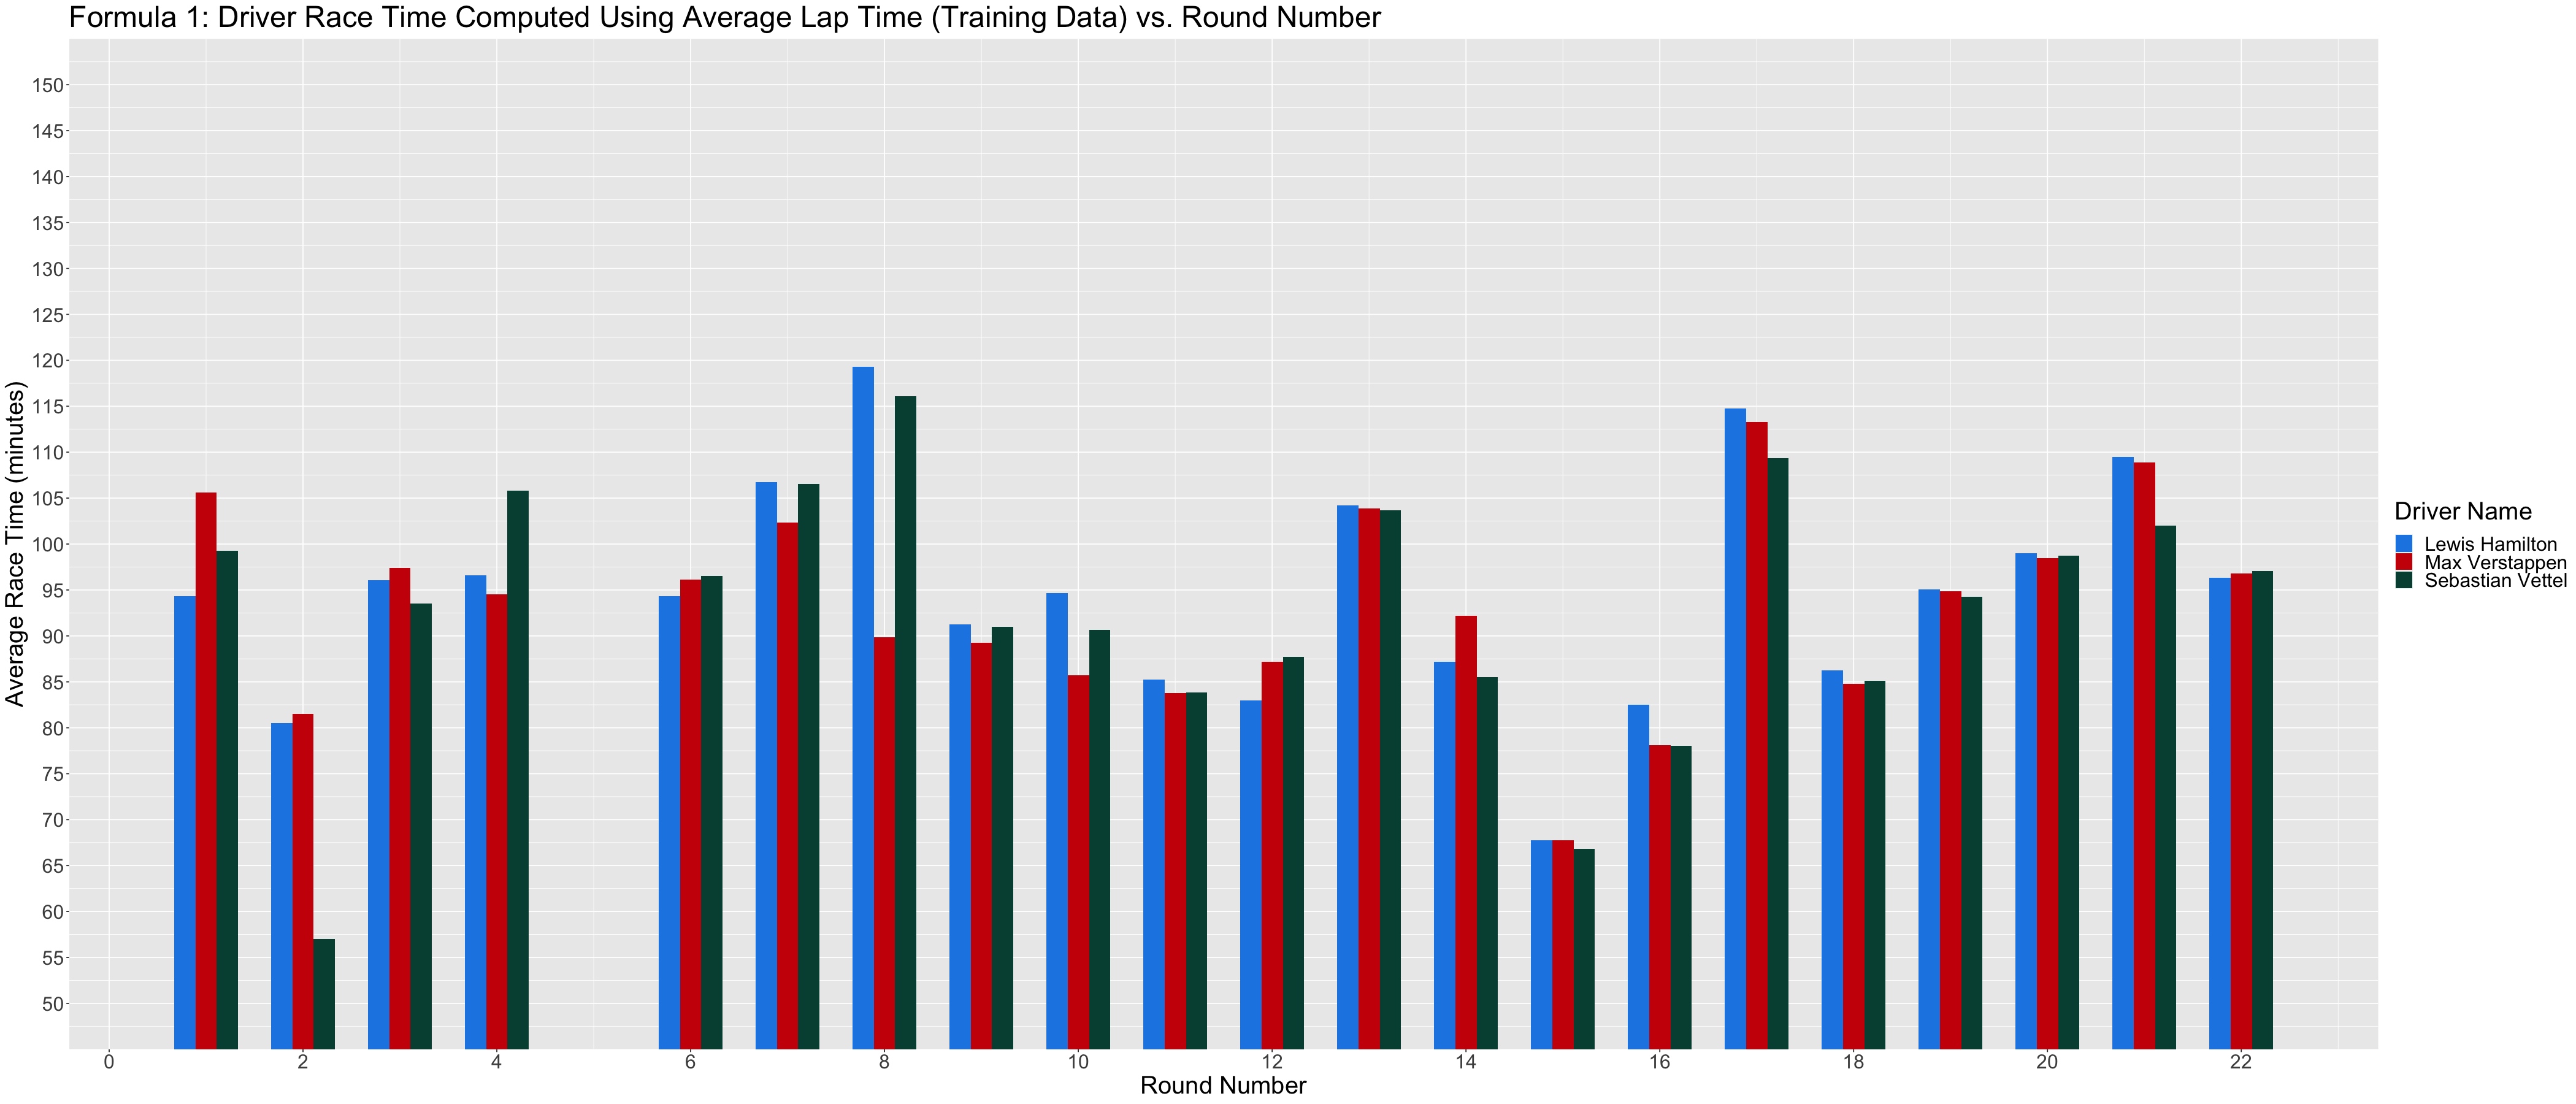

In [218]:
options(repr.plot.width = 35, repr.plot.height = 15)

avg_race_time_plot <- ggplot(lcs_race_times, aes(x = round_number, y = avg_lap_racetime_mins, fill = driver_name)) +
                       geom_col(width = 0.66, position = "dodge") +
                        coord_cartesian(ylim=c(50,150)) +
                        labs(x = "Round Number", y = "Average Race Time (minutes)", fill = "Driver Name") +
                        theme(text = element_text(size = 24)) + 
                        scale_fill_manual(values=c("#1E88E5", "#CC0907", "#004D40")) +
                        ggtitle("Formula 1: Driver Race Time Computed Using Average Lap Time (Training Data) vs. Round Number") +
                        scale_x_continuous(breaks = seq(0, 22, 2)) +  
                        scale_y_continuous(breaks = seq(50, 150, 5))
                        
avg_race_time_plot

As it can be seen the lap times, vary from race to race for each driver and are quite close, indicating that the data will be reliable for the predictive analysis.

## Phase 4: Predictive Data Analysis

To formulate how exactly  **lap times** will be used as the metric of performance, we examined the trend of lap times for a random current driver, Sergio Perez. Using their lap data, we filtered `per_laps` by `race_Id` to focus on a random location, Japan, using `japan_race_ID`. Subsequently, creating a scatter plot as shown below:

Warning message:
“Removed 16 rows containing missing values (geom_point).”


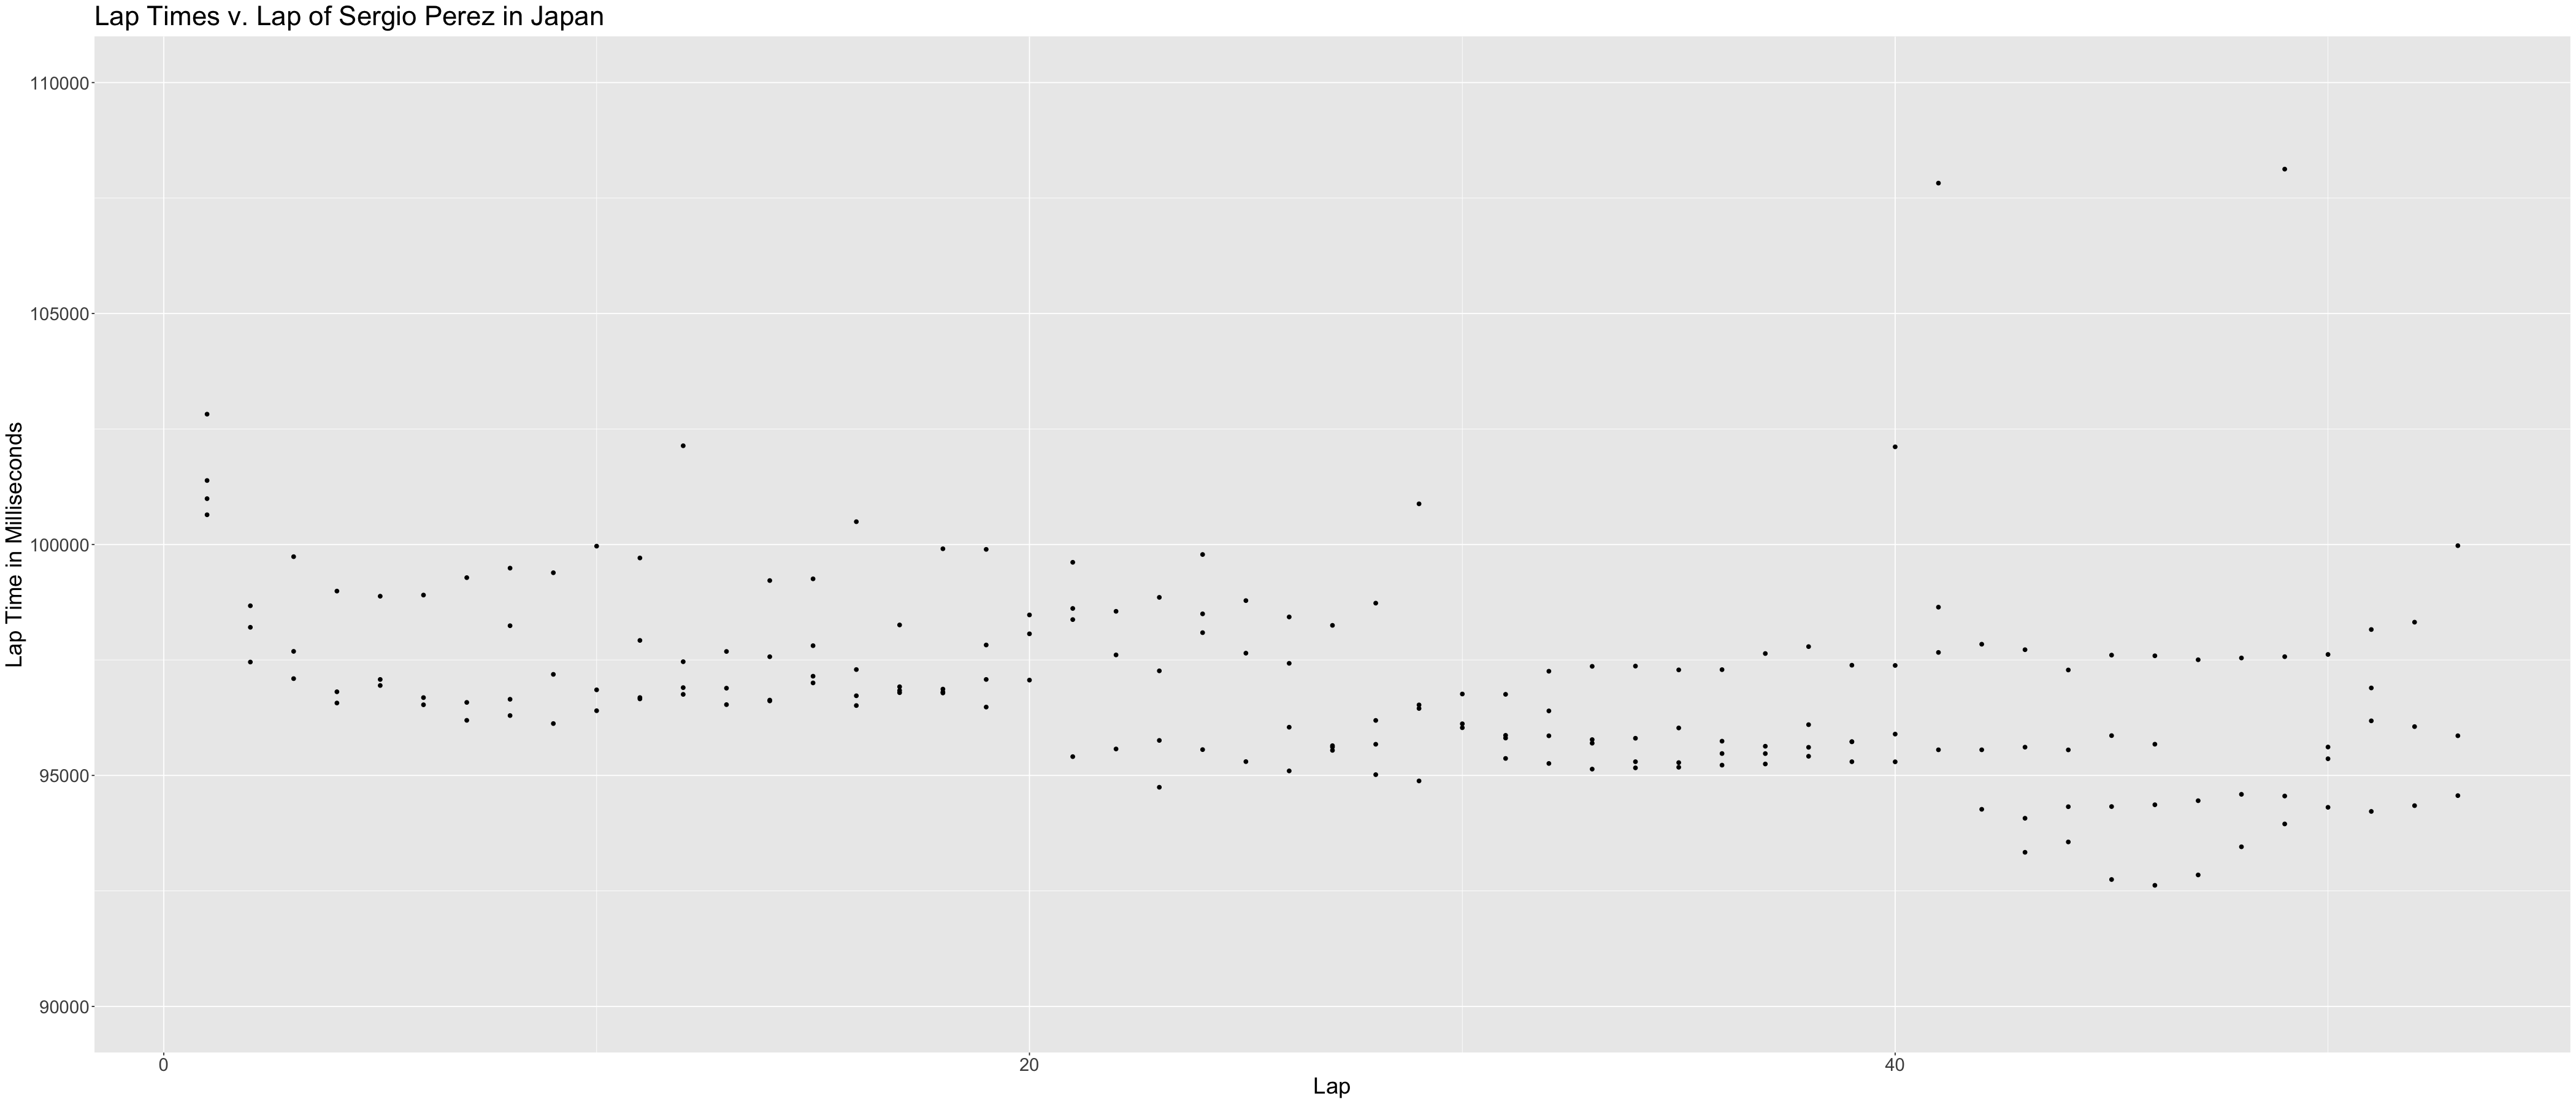

In [219]:
lap_vis_data <- per_laps %>%
                filter(raceId %in% japan_race_ID)
    

lap_vis <- ggplot(lap_vis_data, aes(x = lap, y = milliseconds)) + 
            geom_point() +
            labs(x = "Lap", y = "Lap Time in Milliseconds") +
            ggtitle("Lap Times v. Lap of Sergio Perez in Japan") + 
            theme(text = element_text(size = 22)) + 
            ylim(c(90000,110000))

lap_vis 

The pretext for this predictive analysis certainly does not fit that of classification or clustering. It would be ideal to assess drivers using their lap data at each of the 22 locations to predict a race time for that race using regression.

Given that we are trying to predict `milliseconds` using `lap`. K-nearest neighbours regression would not be the best choice as multiple exact observations already exist for `lap`. Linear regression would be suited much better for this task since the trend between `milliseconds` and `lap` is expected to be quite linear throughout a race. 

### 4.1 - Linear Regression Process

#### 4.1.1 - Using Functions To Abstract Data Analysis

Predicting a total of 22 race times for 20 drivers, amounting to a total of 440 regression models, would be extremely time-consuming. Hence we will be utilizing functions to expedite this process:

We have broken up the process of linear regression to take place using two functions: 

1. initiate_split_data 
2. initiate_linear_regression

**initiate_linear_regression**:

1. Creates a model specification. 

2. Creates a recipe using `milliseconds` as the response variable and a single predictor `lap` using `formulaone_train`.

3. Combines the model and recipe using a workflow and fits the training data onto it.

4. Uses `formulaone_fit` and `formulaone_test` to predict and bind all race times. After which, it uses the metrics function to obtain all metrics related to the regression model. 

5.  Plots the training data as `lap` versus `milliseconds` overlaying the model prediction as a blue line. 

In [220]:
initiate_linear_regression <- function(){
    
    #1. 
    
    formulaone_spec <<- linear_reg() %>%
      set_engine("lm") %>%
      set_mode("regression")

    #2. 
    
    formulaone_recipe <<- recipe(milliseconds ~ lap, data = formulaone_train)

    #3.
    
    formulaone_fit <<- workflow() %>%
      add_recipe(formulaone_recipe) %>%
      add_model(formulaone_spec) %>%
      fit(data = formulaone_train)

    #4. 
    
    formulaone_test_results <<- formulaone_fit %>%
      predict(formulaone_test) %>%
      bind_cols(formulaone_test) %>%
      metrics(truth = milliseconds, estimate = .pred)

    #5. 
    
    formulaone_plot_final <<- ggplot(formulaone_train, aes(x = lap, y = milliseconds)) +
      geom_point(alpha = 0.4) +
      xlab("Lap") +
      ylab("Milliseconds") +
      geom_smooth(method = "lm", se = FALSE) +
      ggtitle("Predicted Lap Times vs. Laps") +
      theme(text = element_text(size = 30))

    formulaone_plot_final
}

#### 4.1.2 - Applying Functions In Predicting Race Time For A Sample Driver

We will now predict the race time for Fernando Alonso for the sample race round seven in Monaco in 5 steps:

1. Set the seed and then filter `alo_laps` by `raceId` for all races in `monaco_race_ID`. 

2. Group all observations in  `fa_monaco` by `raceId`, arranging them in numerically decreasing order of their number of laps.

3. Pull the `race_Id`'s as a vector into `fa_monaco_clean_ID`.

4. Filter the `alo_laps` by `raceId` for only those `raceId`'s present in `fa_monaco_clean_ID` and remove any outliers.

5. Split `fa_monaco_races` into the training and testing sets assigning it to `formulaone_split`.

> Note: Considering the specific time frame of races, in which some drivers may have more data than others. Our main priority is to build a robust model. Hence, we set `prop = 0.75` to build a more robust model that has "seen" more data, while also allowing its fair assessment.

In [221]:
set.seed(2022)

#Round 7 - Monaco

### PRE-REGRESSION FILTERING

#1

fa_monaco <- alo_laps %>%
                filter(raceId %in% monaco_race_ID)

head(fa_monaco)

#2

fa_monaco_clean <- fa_monaco %>%
                    group_by(raceId) %>%
                    summarize(n = n()) %>%
                    arrange(desc(n)) 

fa_monaco_clean

#3

fa_monaco_clean_ID <- fa_monaco_clean %>%
                        pull(raceId)

fa_monaco_clean_ID

#4 

fa_monaco_races <- alo_laps %>%
                    filter(raceId %in% fa_monaco_clean_ID) %>%
                    arrange(by = desc(milliseconds)) %>%
                    slice(3:1000)

head(fa_monaco_races)

#5 

formulaone_split <- initial_split(fa_monaco_races, prop = 0.75, strata = milliseconds)

raceId,driverId,lap,position,time,milliseconds
<dbl>,<dbl>,<dbl>,<dbl>,<time>,<dbl>
953,4,1,8,02:35:00,155781
953,4,2,8,02:13:00,133519
953,4,3,8,02:08:00,128107
953,4,4,8,02:08:00,128432
953,4,5,8,02:09:00,129161
953,4,6,8,02:09:00,129335


raceId,n
<dbl>,<int>
953,78
1056,77
994,52


[1]  953 1056  994

raceId,driverId,lap,position,time,milliseconds
<dbl>,<dbl>,<dbl>,<dbl>,<time>,<dbl>
953,4,6,8,02:09:00,129335
953,4,5,8,02:09:00,129161
953,4,4,8,02:08:00,128432
953,4,3,8,02:08:00,128107
953,4,7,8,02:06:00,126434
953,4,9,8,01:57:00,117520


Before initiating linear regression, we call `initiate_split_data` to separate the split data. 

In [222]:
### SEPARATES DATA

initiate_split_data()

#______________________________

head(formulaone_train)

head(formulaone_test)

raceId,driverId,lap,position,time,milliseconds
<dbl>,<dbl>,<dbl>,<dbl>,<time>,<dbl>
1056,4,20,14,01:17:00,77648
1056,4,18,14,01:17:00,77636
1056,4,43,12,01:17:00,77602
1056,4,14,14,01:17:00,77529
994,4,22,9,01:17:00,77484
1056,4,31,13,01:17:00,77473


raceId,driverId,lap,position,time,milliseconds
<dbl>,<dbl>,<dbl>,<dbl>,<time>,<dbl>
953,4,9,8,01:57:00,117520
953,4,8,8,01:54:00,114138
953,4,10,8,01:46:00,106046
953,4,35,5,01:42:00,102965
953,4,12,8,01:39:00,99583
953,4,19,9,01:37:00,97085


Consequently we call initiate_linear_regression and confirm that all steps are being carried out correctly:

`geom_smooth()` using formula 'y ~ x'



Linear Regression Model Specification (regression)

Computational engine: lm 


Recipe

Inputs:

      role #variables
   outcome          1
 predictor          1

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)          lap  
    89879.3       -176.7  


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,8659.9901031
rsq,standard,0.2174498
mae,standard,6278.0747118


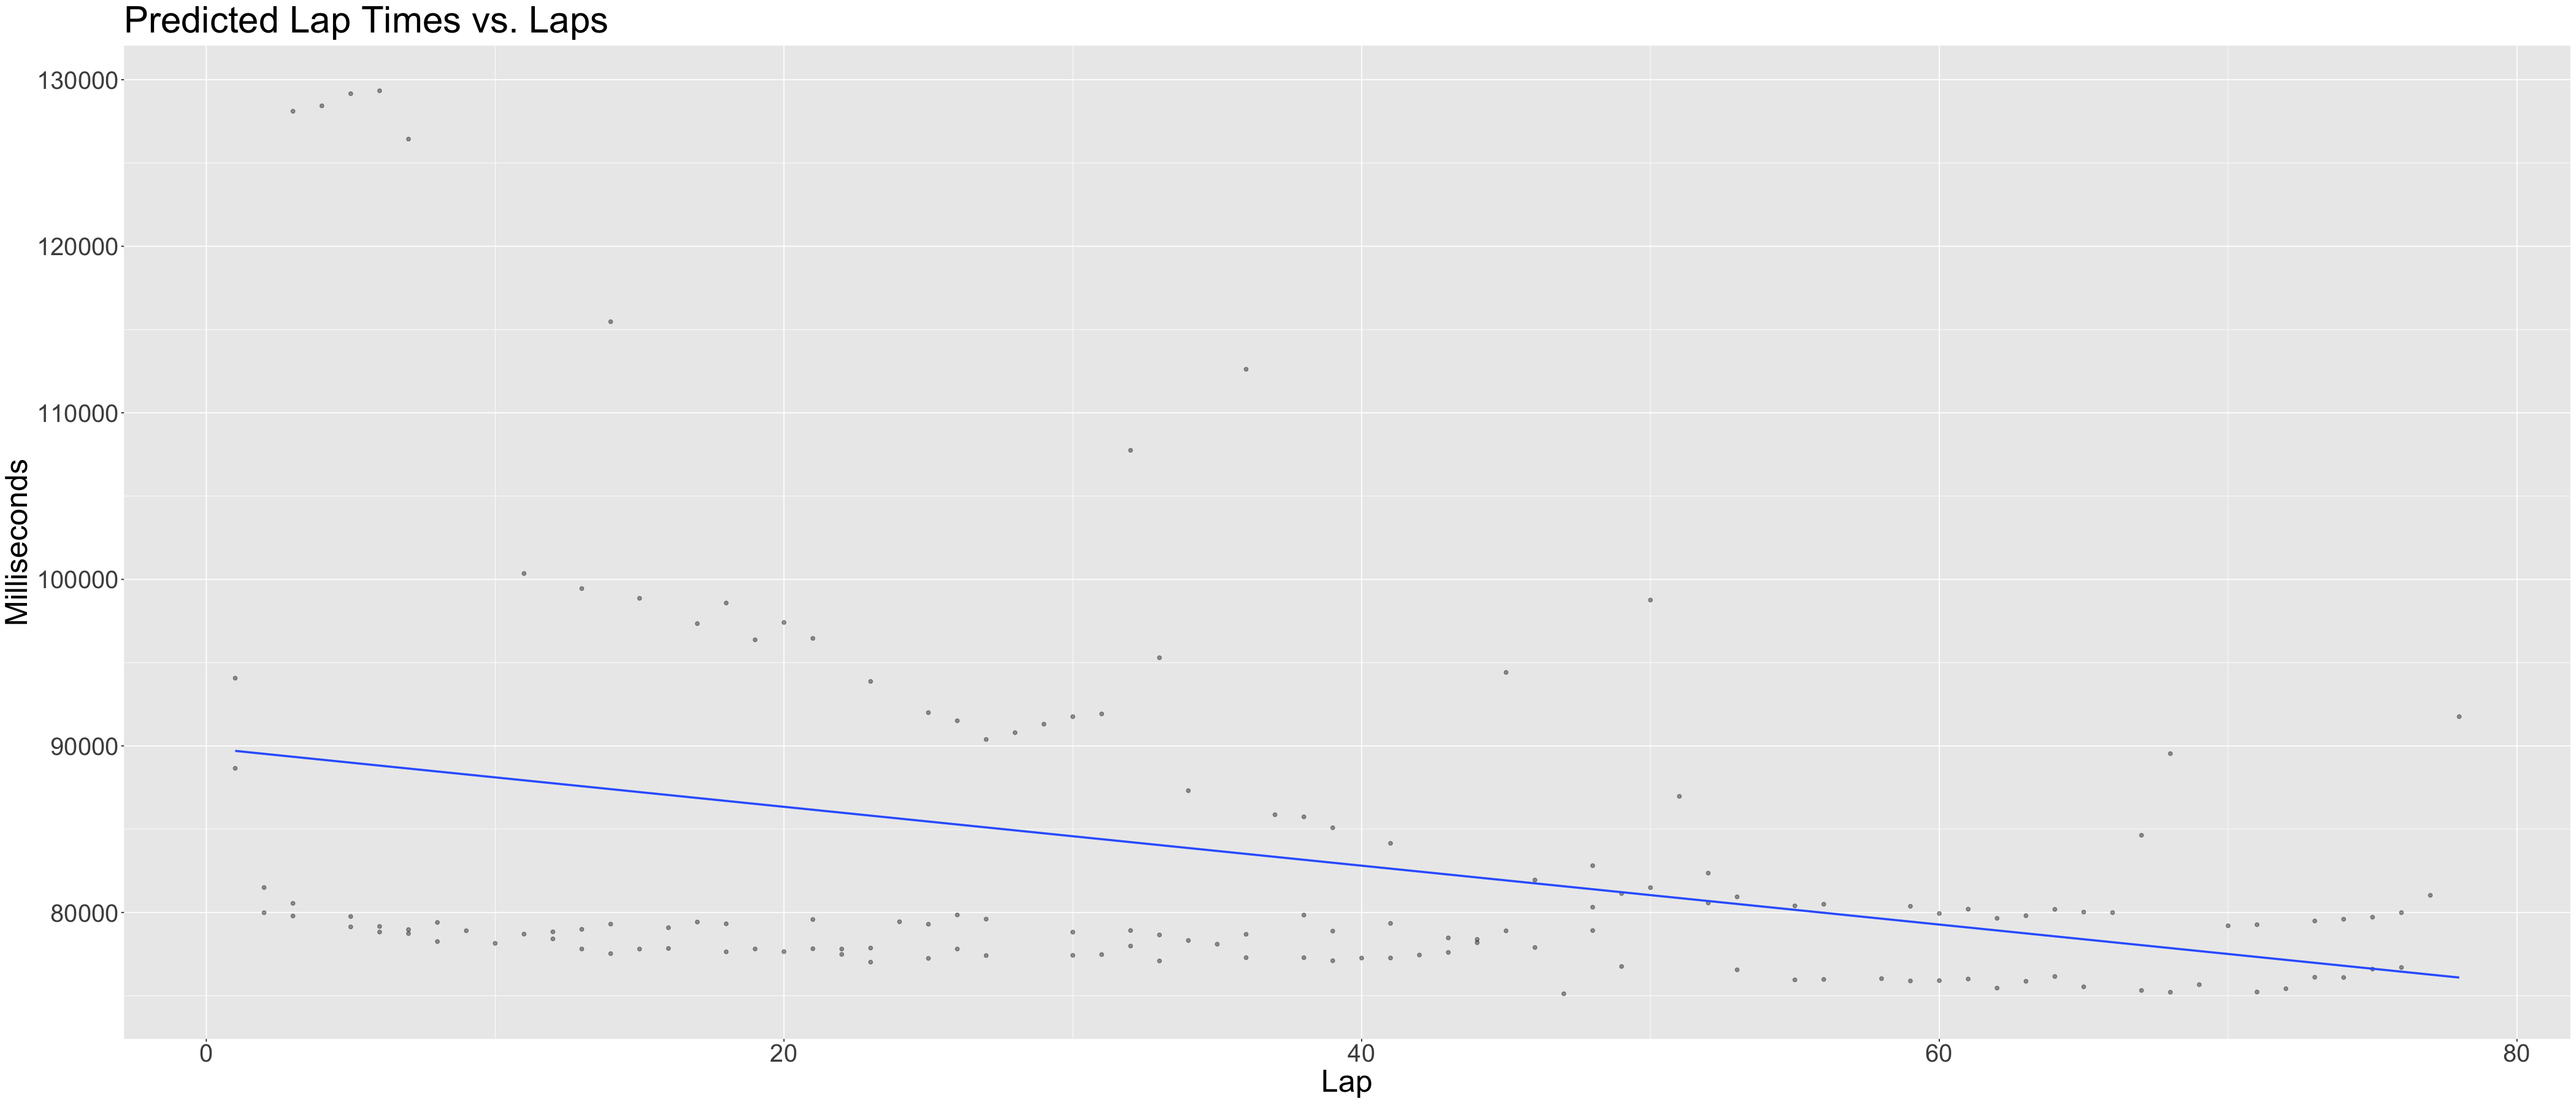

In [223]:
### RUNS REGRESSION

initiate_linear_regression()

#______________________________

formulaone_spec

formulaone_recipe

formulaone_fit

formulaone_test_results

#### 4.1.3 - Extracting Regression Evaluation

An additional function `initiate_rmse` was created to assist in filtering `formulaone_test_results` for the **root mean square prediction error**, and adding the round of race specified:

In [224]:
initiate_rmse <- function(){
  race_rmse <<- formulaone_test_results %>% 
                    filter(.metric == "rmse") %>% 
                    mutate(Round = round_n)
  race_rmse
    
  rmse_col <<- rbind(rmse_col, race_rmse)
}

Factoring in that many additional models will need to be created for one driver we created a collection object `rmse_col` in which all `race_rmse`'s are automatically collected. As the regression for each driver is carried out round by round, `initiate_rmse` ensures that all needed results are filtered and collected all at once. 

We first specify the collection data frame `rmse_col`, with the exact column names as specified before.

In [225]:
rmse_col <- data.frame(.metric = character(), .estimator = character(), .estimate = double(), Round = double(), stringsAsFactors = FALSE) 

rmse_col

.metric,.estimator,.estimate,Round
<chr>,<chr>,<dbl>,<dbl>


After specifying `round_n = 7`, we collect the filtered results of the regression carried out above into the "bin". 

In [226]:
round_n <- 7

initiate_rmse() 

rmse_col

.metric,.estimator,.estimate,Round
<chr>,<chr>,<dbl>,<dbl>
rmse,standard,8659.99,7


> Note: Calling `initiate_rmse()` more than once results in duplicated observations. This is fixed by re-running `rmse_col`.

It appears that all steps have been executed correctly and `rmse_col` only contains the rmspe, which is the exact value of 8659.99 as seen above. This value represents the error that is possibly present between in all predicted lap times in milliseconds. 

#### 4.1.4 Combining Lap Times into Race Time

To predict a race time for each driver at each race, we can use the model to predict a race for each of the number of laps in a given race by using the number of laps currently scheduled.

Knowing that many of the 22 scheduled races differ in the number of laps, we create a function named, get_*location*_prediction.`get_monaco_prediction` has been specifically created to attain the race time for all drivers in Monaco in 4 steps:

1. Uses `predict` with `formulaone_fit`, as well as a table of laps numbered 1-78, as obtained from https://www.formula1.com/en/racing/2022/Monaco/Circuit.html, to predict times for all laps and summarizes them to obtain a race time.

2. Adds columns `race_time_mins` and`race_time_hrs` for the race time in minutes and hours,`round_n` specified the round.

3. Given that additional race times will be calculated, we again use an automatic collection process binding `predict_all` to `racetime_col`, which will collect all 22 race times for one driver.

In [227]:
get_monaco_prediction <- function(){
    
    #1
    predict_ms <<- predict(formulaone_fit, tibble(lap = c(1:78))) %>%
        mutate(lap = 1:78) %>%
        summarise(race_time_milliseconds = sum(.pred)) 

    #2
    predict_mins <<- predict_ms %>%
        mutate(race_time_mins = race_time_milliseconds/60000)
    
    predict_all <<- predict_mins %>%
         mutate(race_time_hrs = race_time_milliseconds/3600000) %>% 
         mutate(Round = round_n)
    
    #3
    racetime_col <<- rbind(racetime_col, predict_all)
    
    predict_all
}


The process is demonstrated below:

In [228]:
## Create Bin (Step 0)

racetime_col <- data.frame(race_time_milliseconds = double(), race_time_mins = double(), race_time_hrs = double()) 

racetime_col

race_time_milliseconds,race_time_mins,race_time_hrs
<dbl>,<dbl>,<dbl>


In [229]:
get_monaco_prediction()

#____________

racetime_col

race_time_milliseconds,race_time_mins,race_time_hrs,Round
<dbl>,<dbl>,<dbl>,<dbl>
6466044,107.7674,1.796123,7


race_time_milliseconds,race_time_mins,race_time_hrs,Round
<dbl>,<dbl>,<dbl>,<dbl>
6466044,107.7674,1.796123,7


It can be seen that `predict_all` first automatically prints as expected and manually printing `racetime_col` shows that `racetime_col` was successfully and correctly updated.

### 4.2 - Regression Scaling

But how can this process be repeated 439 more times? 

To answer this, we thoughtfully examined phases 1, 3, and 4.1 to identify major similarities. Although we could have done all of the 440 regression models in this file, it would have been extremely inefficient and visually unappealing. As such we decided to structure our entire process for all drivers and races across the season as follows: 

#### 4.2.1 - Organizing Remote Repository 

In the project remote repository, we created a directory `Lap_Wrangling` and added 20 .ipynb files each corresponding to the race time regression models for a driver.

#### 4.2.2 - Abstracting Code

To reduce repetition in the analysis amongst all 20 files, we then created a sub-directory `source` wherein all common data would be placed. 

We abstracted Phases 1.1, and 2.1 - 2.4 into a file named `master_functions.r` wherein we created 5 functions:

1. initialize_data() - containing all data read from the web (Phase 1.1)

Using data in initialize_data(): 

2. initialize_circuits() - containing all circuit wrangling (Phase 2.1)
3. initialize_constructors() - containing all construcutor wrangling (Phase 2.2)
4. initialize_drivers() - containing all driver wrangling (Phase 2.3)
5. initialize_courses() - containing all race wrangling (Phase 2.3)
        
These 5 functions would be initialized by a master function `initialize_master`. Allowing us to possess all shared data between 20 files by loading `master_functions.r` and then calling `initialize_master()`.  

We also created another file `regression.r` wherein we placed `initiate_split_data`, `initiate_linear_regression`, and `initiate_rmse` (phases 4.1.2 and 4.1.3). 

Since the vast majority of the 22 race circuits have a different number of total laps, we created another file in `source` named `prediction.r` wherein we created 22 different functions for obtaining predictions on all of the circuits.

#### 4.2.3 - Driver File Structure

All 20 driver files were structured and designed to carry out this prediction process as follows: 

1. Load all required libraries and source code files. 

2. Filter lap data (2.5) with the base filter in each file and only driver-specific laps

3. Create the `racetime_col` and `rmse_col` data frames for automatic result collection. 

4. Create 22 separate cells placing and editing all parts of phases 4.1.2 - 4.1.4 into each cell for the corresponding round.

5. Checking `racetime_col` and `rmse_col` to ensure that 22 observations were collected in each.

6. Merging both data frames as one and exporting to sub_directory in lap_wrangling named `final_race_data`.

All of above files can be found at https://github.com/TaylorOglow/Formula_1/tree/main/Lap%20Wrangling/source. For simplicity, we will proceed by simply loading the results in the results section.

### 4.3 - Regression Complications

In a sport as dynamic as Formula 1, driver lineups are bound to change across seasons. Resulting in differing amounts of data at all locations. 
While conducting the data analysis, a lack of data was discovered for some drivers. 

In such a situation, a few options came to light. Firstly, replace any missing data using race data from other racing competitions. This would be extremely time-consuming since a lot of additional data will need to be obtained and wrangled for each driver. More importantly, this won't be as comparative since the origin of data will be entirely different from Formula 1. 

However, in almost every season in the past decade, driver performance has been quite relational to the team. As such, with minimal changes, using data for all drivers that have raced for the selected team, we replaced any missing data by:

1. Making a list of drivers that have raced for the selected constructor since 2015. 

2. Using lap data filtered by the selected driverId's that were additionally included 2.3.

Having no previous data for Zhou Guanyu who races for Alfa Romeo in his first season in F1, we used archived records from https://www.formula1.com/en/results.html/1950/races/94/great-britain/race-result.html. After which we used lap data for past Alfa Romeo drivers Kimi Raikkonen, Robert Kubica and Antonio Giovinazzi. Using their driverId the data was filled as follows:

In [230]:
# PREVIOUS CODE

# lap_data <- lap_times %>%
#             filter(driverId %in% driver_ids) %>%
#             filter(raceId %in% race_ids)

# zho_laps <- lap_data %>%
#             filter(driverId == 855)


# NEW CODE
#-------------

# Filtering Lap Data for ALFA ROMEO

romeo_lap <- lap_data %>%
             filter(driverId %in% c(8, 841, 9))

> Note: Although Zhou Guanyu had no data, for other drivers with partially missing data, this same method was applied and used in addition to the original method, as needed.

# Results

## Phase 5: Loading Regression Results

It is now time to import all predicted results for the 20 different drivers using `read_csv` from the `Formula_1 Repository`:

In [231]:
### Final Race Time Data

aa_race <- read_csv("https://raw.githubusercontent.com/TaylorOglow/Formula_1/main/Lap%20Wrangling/final_race_data/aa_race.csv")

cl_race <- read_csv("https://raw.githubusercontent.com/TaylorOglow/Formula_1/main/Lap%20Wrangling/final_race_data/cl_race.csv")

cs_race <- read_csv("https://raw.githubusercontent.com/TaylorOglow/Formula_1/main/Lap%20Wrangling/final_race_data/cs_race.csv")

dr_race <- read_csv("https://raw.githubusercontent.com/TaylorOglow/Formula_1/main/Lap%20Wrangling/final_race_data/dr_race.csv")

eo_race <- read_csv("https://raw.githubusercontent.com/TaylorOglow/Formula_1/main/Lap%20Wrangling/final_race_data/eo_race.csv")

fa_race <- read_csv("https://raw.githubusercontent.com/TaylorOglow/Formula_1/main/Lap%20Wrangling/final_race_data/fa_race.csv")

gr_race <- read_csv("https://raw.githubusercontent.com/TaylorOglow/Formula_1/main/Lap%20Wrangling/final_race_data/gr_race.csv")

km_race <- read_csv("https://raw.githubusercontent.com/TaylorOglow/Formula_1/main/Lap%20Wrangling/final_race_data/km_race.csv")

lh_race <- read_csv("https://raw.githubusercontent.com/TaylorOglow/Formula_1/main/Lap%20Wrangling/final_race_data/lh_race.csv")

ln_race <- read_csv("https://raw.githubusercontent.com/TaylorOglow/Formula_1/main/Lap%20Wrangling/final_race_data/ln_race.csv")

ls_race <- read_csv("https://raw.githubusercontent.com/TaylorOglow/Formula_1/main/Lap%20Wrangling/final_race_data/ls_race.csv")

ms_race <- read_csv("https://raw.githubusercontent.com/TaylorOglow/Formula_1/main/Lap%20Wrangling/final_race_data/ms_race.csv")

mv_race <- read_csv("https://raw.githubusercontent.com/TaylorOglow/Formula_1/main/Lap%20Wrangling/final_race_data/mv_race.csv")

nl_race <- read_csv("https://raw.githubusercontent.com/TaylorOglow/Formula_1/main/Lap%20Wrangling/final_race_data/nl_race.csv")

pg_race <- read_csv("https://raw.githubusercontent.com/TaylorOglow/Formula_1/main/Lap%20Wrangling/final_race_data/pg_race.csv")

sp_race <- read_csv("https://raw.githubusercontent.com/TaylorOglow/Formula_1/main/Lap%20Wrangling/final_race_data/sp_race.csv")

sv_race <- read_csv("https://raw.githubusercontent.com/TaylorOglow/Formula_1/main/Lap%20Wrangling/final_race_data/sv_race.csv")

vb_race <- read_csv("https://raw.githubusercontent.com/TaylorOglow/Formula_1/main/Lap%20Wrangling/final_race_data/vb_race.csv")

yt_race <- read_csv("https://raw.githubusercontent.com/TaylorOglow/Formula_1/main/Lap%20Wrangling/final_race_data/yt_race.csv")

zg_race <- read_csv("https://raw.githubusercontent.com/TaylorOglow/Formula_1/main/Lap%20Wrangling/final_race_data/zg_race.csv")

Rows: 22 Columns: 7

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): .metric, .estimator
dbl (5): Round, .estimate, race_time_milliseconds, race_time_mins, race_time...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 22 Columns: 7

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): .metric, .estimator
dbl (5): Round, .estimate, race_time_milliseconds, race_time_mins, race_time...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 22 Columns: 7

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): .metric, .estimator
dbl (5): Round, .estimate, race_time_milliseconds, race_time_mins, race_time...


ℹ Use 

## Phase 6: Wrangling Regression Results

Loading a sample shows that almost all information needed to predict the standings is present including the rmspe values and race times obtained through linear regression:

In [232]:
head(zg_race)

Round,.metric,.estimator,.estimate,race_time_milliseconds,race_time_mins,race_time_hrs
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,rmse,standard,14317.896,5922126,98.70211,1.645035
2,rmse,standard,12403.730,5556664,92.61107,1.543518
3,rmse,standard,6963.927,5332088,88.86813,1.481136
4,rmse,standard,17466.477,5648278,94.13797,1.568966
5,rmse,standard,9892.404,5779828,96.33047,1.605508
6,rmse,standard,9546.831,5812417,96.87362,1.614560


In order to identify these observations, we first `mutate` to add driver name, `driver`, and their `team` to each of the above objects:

In [233]:
aa_race <- aa_race %>%
            mutate(Driver = "Alexander Albon") %>%
            mutate(Team = "Williams")

cl_race <- cl_race %>%
            mutate(Driver = "Charles Leclerc") %>%
            mutate(Team = "Ferrari")

cs_race <- cs_race %>%
            mutate(Driver = "Carlos Sainz Jr.") %>%
            mutate(Team = "Ferrari")

dr_race <- dr_race %>%
            mutate(Driver = "Daniel Ricciardo") %>% 
            mutate(Team = "McLaren")

eo_race <- eo_race %>%
           mutate(Driver = "Esteban Ocon") %>% 
           mutate(Team = "Alpine")

fa_race <- fa_race %>%
           mutate(Driver = "Fernando Alonso") %>% 
           mutate(Team = "Alpine")

gr_race <- gr_race %>%
           mutate(Driver = "George Russell") %>%
           mutate(Team = "Mercedes")

km_race <- km_race %>%
           mutate(Driver = "Kevin Magnussen") %>%
           mutate(Team = "Haas F1 Team")

lh_race <- lh_race %>%
           mutate(Driver = "Lewis Hamilton")  %>%
           mutate(Team = "Mercedes")

ln_race <- ln_race %>%
           mutate(Driver = "Lando Norris") %>% 
           mutate(Team = "McLaren")

ls_race <- ls_race %>%
           mutate(Driver = "Lance Stroll") %>%
           mutate(Team = "Aston Martin")

ms_race <- ms_race %>%
           mutate(Driver = "Mick Schumacher") %>%
           mutate(Team = "Haas F1 Team")

mv_race <- mv_race %>%
           mutate(Driver = "Max Verstappen") %>%
           mutate(Team = "Red Bull Racing")

nl_race <- nl_race %>%
           mutate(Driver = "Nicholas Latfifi") %>%
           mutate(Team = "Williams")

pg_race <- pg_race %>%
           mutate(Driver = "Pierre Gasly")  %>%
           mutate(Team = "AlphaTauri")

sp_race <- sp_race %>%
           mutate(Driver = "Sergio Pérez") %>%
           mutate(Team = "Red Bull Racing")

sv_race <- sv_race %>%
           mutate(Driver = "Sebastian Vettel")  %>%
           mutate(Team = "Aston Martin")

vb_race <- vb_race %>%
           mutate(Driver = "Valtteri Bottas") %>%
           mutate(Team = "Alfa Romeo")

yt_race <- yt_race %>%
           mutate(Driver = "Yuki Tsunoda") %>%
           mutate(Team = "AlphaTauri")

zg_race <- zg_race %>%
           mutate(Driver = "Zhou Guanyu") %>%
           mutate(Team = "Alfa Romeo")

## Phase 7: Simulating World Championship

Now, to determine driver finish according to race time, we first bind all 22 tibbles using `rbind`. Grouping by the `round` of the race we arrange by the times and assign a finish based on the row number:

In [252]:
season_combined <- rbind(aa_race, cl_race, cs_race, dr_race, eo_race, fa_race, gr_race, km_race, lh_race, ln_race, ls_race, ms_race, mv_race,
                          nl_race, pg_race, sp_race, sv_race, vb_race, yt_race, zg_race) %>% 
                            group_by(Round) %>% 
                            arrange(by = race_time_milliseconds) %>%
                            mutate(Finish = row_number()) %>%
                            arrange(by = Finish)

season_combined

Round,.metric,.estimator,.estimate,race_time_milliseconds,race_time_mins,race_time_hrs,Driver,Team,Finish
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>
16,rmse,standard,8244.506,4659130,77.65216,1.294203,Lewis Hamilton,Mercedes,1
10,rmse,standard,14043.819,4998205,83.30341,1.388390,Charles Leclerc,Ferrari,1
11,rmse,standard,5168.355,5029589,83.82648,1.397108,Max Verstappen,Red Bull Racing,1
14,rmse,standard,17945.357,5055526,84.25876,1.404313,Charles Leclerc,Ferrari,1
18,rmse,standard,1278.865,5070250,84.50417,1.408403,Alexander Albon,Williams,1
4,rmse,standard,7670.133,5082756,84.71260,1.411877,Kevin Magnussen,Haas F1 Team,1
12,rmse,standard,11788.912,5232990,87.21650,1.453608,Lewis Hamilton,Mercedes,1
3,rmse,standard,2046.781,5234982,87.24970,1.454162,Pierre Gasly,AlphaTauri,1
15,rmse,standard,4132.673,5372088,89.53480,1.492247,Max Verstappen,Red Bull Racing,1


The final step in predicting the standings is to assign the number of points based on their finish for each race. Referencing https://en.wikipedia.org/wiki/Formula_One_racing#:~:text=Current%20system,Position&text=Points%20are%20awarded%20to%20drivers,positions%203%20through%2010%2C%20, we create a vector `points` with the number of points based on the finish from 1 to 20. We then group by `round` and add a points column with the number of awarded points for that finish to `season_points` for each race:

In [235]:
points <- c(25, 18, 15, 12, 10, 8, 6, 4, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)


season_points <- season_combined %>% 
                    group_by(Round) %>%
                    mutate(Points = (Finish * 0) + points)

head(season_points)
tail(season_points)

Round,.metric,.estimator,.estimate,race_time_milliseconds,race_time_mins,race_time_hrs,Driver,Team,Finish,Points
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<dbl>
16,rmse,standard,8244.506,4659130,77.65216,1.294203,Lewis Hamilton,Mercedes,1,25
10,rmse,standard,14043.819,4998205,83.30341,1.388390,Charles Leclerc,Ferrari,1,25
11,rmse,standard,5168.355,5029589,83.82648,1.397108,Max Verstappen,Red Bull Racing,1,25
14,rmse,standard,17945.357,5055526,84.25876,1.404313,Charles Leclerc,Ferrari,1,25
18,rmse,standard,1278.865,5070250,84.50417,1.408403,Alexander Albon,Williams,1,25
4,rmse,standard,7670.133,5082756,84.71260,1.411877,Kevin Magnussen,Haas F1 Team,1,25


Round,.metric,.estimator,.estimate,race_time_milliseconds,race_time_mins,race_time_hrs,Driver,Team,Finish,Points
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<dbl>
20,rmse,standard,6191.390,6124838,102.0806,1.701344,Mick Schumacher,Haas F1 Team,20,0
13,rmse,standard,11381.998,6221508,103.6918,1.728197,Lewis Hamilton,Mercedes,20,0
22,rmse,standard,4695.724,6263385,104.3897,1.739829,Nicholas Latfifi,Williams,20,0
7,rmse,standard,12363.503,6536707,108.9451,1.815752,Kevin Magnussen,Haas F1 Team,20,0
21,rmse,standard,23688.074,6771402,112.8567,1.880945,Valtteri Bottas,Alfa Romeo,20,0
17,rmse,standard,19178.034,7483396,124.7233,2.078721,Esteban Ocon,Alpine,20,0


## Phase 8: Visualizing Results

### Constructors' World Championship

Having gathered all data, we proceed to visualizing the results:

Using `season_points`, we condense the data frame to include only the variables `Team` and `Points` grouping by `Team`.  

In [251]:
constructor_filtered <- season_points %>%
                             select(Team, Points) %>%
                             group_by(Team) 

constructor_filtered

Adding missing grouping variables: `Round`



Round,Team,Points
<dbl>,<chr>,<dbl>
16,Mercedes,25
10,Ferrari,25
11,Red Bull Racing,25
14,Ferrari,25
18,Williams,25
4,Haas F1 Team,25
12,Mercedes,25
3,AlphaTauri,25
15,Red Bull Racing,25


We then summarize by adding the points collected by each team through all 22 races:

In [237]:
constructors_championship <- constructor_filtered %>%
                            summarize_all(sum) %>%
                            arrange(by = desc(Points))

constructors_championship

Team,Round,Points
<chr>,<dbl>,<dbl>
Mercedes,506,318
Ferrari,506,303
Williams,506,296
Red Bull Racing,506,264
McLaren,506,261
AlphaTauri,506,236
Aston Martin,506,222
Alfa Romeo,506,198
Haas F1 Team,506,77


Finally, we plot the results as a bar chart, as `Team` versus `Points` filling by team color: 

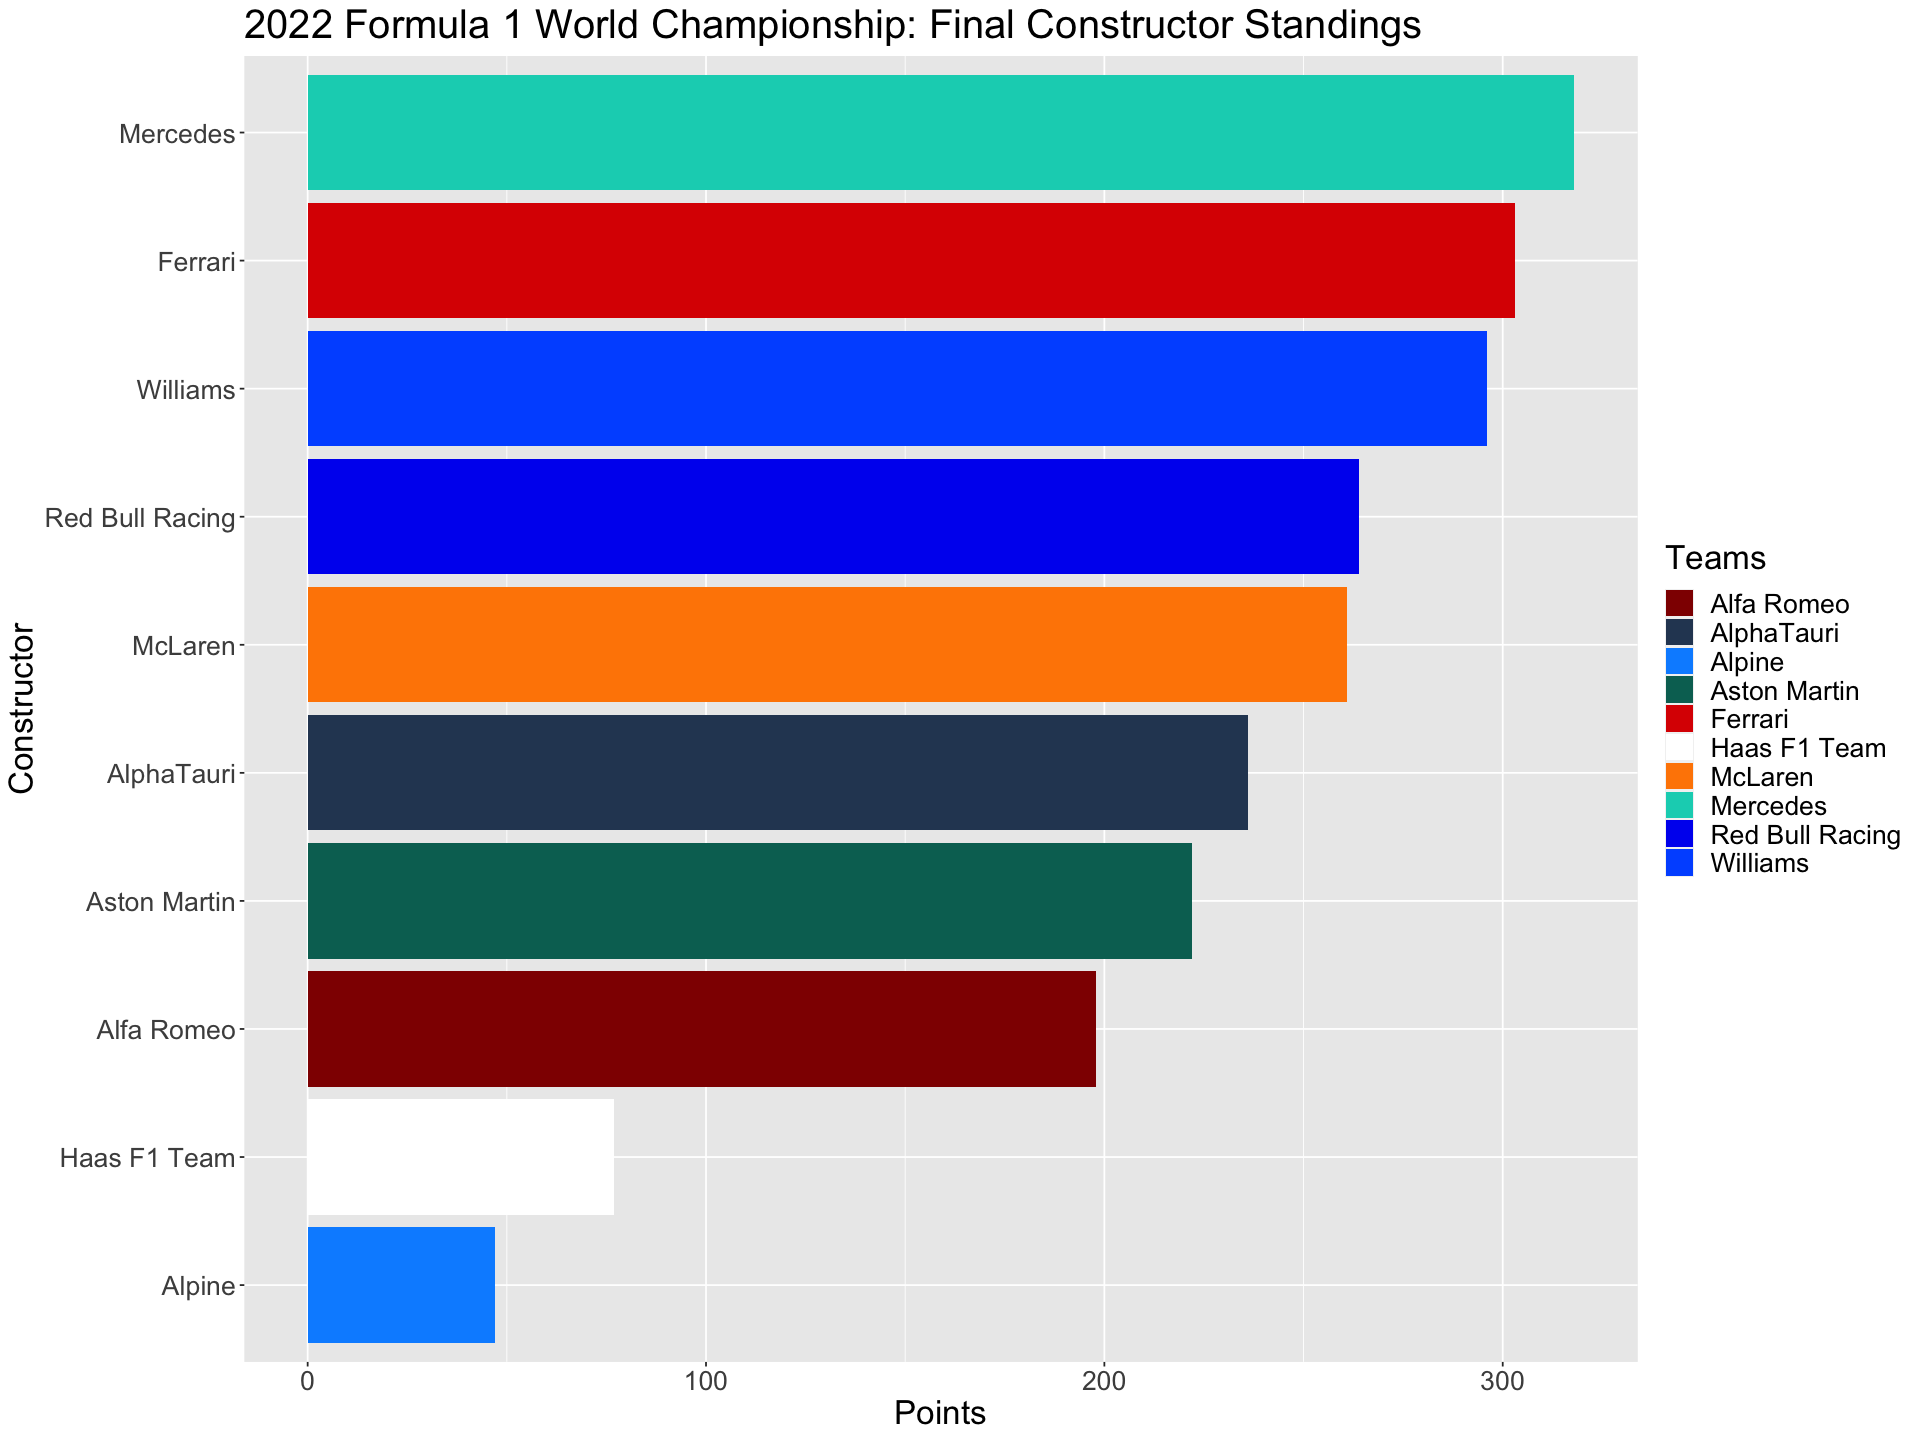

In [238]:
options(repr.plot.width = 16, repr.plot.height = 12)

constructor_bar <- constructors_championship %>% 
    ggplot(aes(reorder(Team, Points), Points, fill = Team)) +
    geom_bar (stat = "identity") +
    scale_fill_manual(values = c("#900000", "#2B4562", "#0090FF", "#006F62", "#DC0000", 
                                 "#FFFFFF", "#FF8700", "#00D2BE", "#0600EF", "#005AFF"))+ 
    labs (title = "2022 Formula 1 World Championship: Final Constructor Standings", x = "Constructor",
             y = "Points",  fill = "Teams")  + 
      theme(text = element_text(size = 20))

constructor_flipped <- constructor_bar + coord_flip()

constructor_flipped

Altogether, this bar chart represents the constructor standings at the end of the predicted 2022 season.

### Drivers' World Championship

Moving to the Drivers' World Championship, we now visualize the results for drivers as two line plots showing the accumulation of points for a driver throughout the season.  

To create such a chart, we must first wrangle the results to obtain the trend of points:

To speed things up, we created a function named **get_points** which: 

1. Counts the number of points awarded to a driver at the end of each round applying `sum` inside `with`.
2. Creates a vector of all point values `points`.
3. Converts `points` to a data frame adding the round number and driver name specified through object `name` for all races.
4. Binds `point` to a collection data frame, used for storing results of all drivers.

In [242]:
get_points <- function(){
    
    #1
    
    driver1 <<- driver_points %>%
            with(sum(Points[Round <= 1]))

    driver2 <<- driver_points %>%
            with(sum(Points[Round <= 2]))

    driver3 <<- driver_points %>%
            with(sum(Points[Round <= 3]))

    driver4 <<- driver_points %>%
            with(sum(Points[Round <= 4]))

    driver5 <<- driver_points %>%
            with(sum(Points[Round <= 5]))

    driver6 <<- driver_points %>%
            with(sum(Points[Round <= 6]))

    driver7 <<- driver_points %>%
            with(sum(Points[Round <= 7]))

    driver8 <<- driver_points %>%
            with(sum(Points[Round <= 8]))

    driver9 <<- driver_points %>%
            with(sum(Points[Round <= 9]))

    driver10 <<- driver_points %>%
            with(sum(Points[Round <= 10]))

    driver11 <<- driver_points %>%
            with(sum(Points[Round <= 11]))

    driver12 <<- driver_points %>%
            with(sum(Points[Round <= 12]))

    driver13 <<- driver_points %>%
            with(sum(Points[Round <= 13]))

    driver14 <<- driver_points %>%
            with(sum(Points[Round <= 14]))

    driver15 <<- driver_points %>%
            with(sum(Points[Round <= 15]))

    driver16 <<- driver_points %>%
            with(sum(Points[Round <= 16]))

    driver17 <<- driver_points %>%
            with(sum(Points[Round <= 17]))

    driver18 <<- driver_points %>%
            with(sum(Points[Round <= 18]))

    driver19 <<- driver_points %>%
            with(sum(Points[Round <= 19]))

    driver20 <<- driver_points %>%
            with(sum(Points[Round <= 20]))

    driver21 <<- driver_points %>%
            with(sum(Points[Round <= 21]))

    driver22 <<- driver_points %>%
            with(sum(Points[Round <= 22]))

    #2
    
    points <<- c(driver1, driver2, driver3, driver4, driver5, driver6, driver7, driver8, driver9, driver10, 
                 driver11, driver12, driver13, driver14, driver15, driver16, driver17, driver18, driver19, driver20, driver21, driver22)

    #3
    points <<- data.frame(Points_UTR = points) %>% 
                mutate(Round = row_number()) %>% 
                mutate(Driver = name)
    
    #4
    points_col <<- rbind(points_col, points)

}

We use this function for all drivers to obtain their progression of points:

1. We first create a collection data frame `points_col` 
2. Filter by `Driver` and arrange in increasing `Round` order:
2. Assign the driver name by mutation to `name`
3. Call get_points to obtain the trend

In [243]:
#1

#### points_col is a collection data frame as specified above

points_col <- data.frame(Points_UTR = character(), Round = double(), Driver = character(), stringsAsFactors=FALSE) 

points_col

Points_UTR,Round,Driver
<chr>,<dbl>,<chr>


In [244]:
#2 

driver_points <- season_points %>% 
                filter(Driver == "Alexander Albon") %>%
                arrange(by = Round)  

#3

name <- "Alexander Albon"

#4 
get_points()

points

Points_UTR,Round,Driver
<dbl>,<int>,<chr>
0,1,Alexander Albon
25,2,Alexander Albon
43,3,Alexander Albon
61,4,Alexander Albon
61,5,Alexander Albon
76,6,Alexander Albon
76,7,Alexander Albon
94,8,Alexander Albon
104,9,Alexander Albon


We now do this for the 19 remaining drivers:

In [245]:
driver_points <- season_points %>% 
                filter(Driver == "Carlos Sainz Jr.") %>%
                arrange(by = Round)  

name <- "Carlos Sainz Jr."

get_points()

###############################################################

driver_points <- season_points %>% 
                filter(Driver == "Charles Leclerc") %>%
                arrange(by = Round)  

name <- "Charles Leclerc"

get_points()

###############################################################

driver_points <- season_points %>% 
                filter(Driver == "Daniel Ricciardo") %>%
                arrange(by = Round)  

name <- "Daniel Ricciardo"

get_points()

###############################################################

driver_points <- season_points %>% 
                filter(Driver == "Esteban Ocon") %>%
                arrange(by = Round)  

name <- "Esteban Ocon"

get_points()

###############################################################

driver_points <- season_points %>% 
                filter(Driver == "Fernando Alonso") %>%
                arrange(by = Round)  

name <- "Fernando Alonso"

get_points()

###############################################################


driver_points <- season_points %>% 
                filter(Driver == "George Russell") %>%
                arrange(by = Round)  

name <- "George Russell"

get_points()

###############################################################

driver_points <- season_points %>% 
                filter(Driver == "Kevin Magnussen") %>%
                arrange(by = Round)  

name <- "Kevin Magnussen"

get_points()

###############################################################

driver_points <- season_points %>% 
                filter(Driver == "Lance Stroll") %>%
                arrange(by = Round)  

name <- "Lance Stroll"

get_points()

###############################################################

driver_points <- season_points %>% 
                filter(Driver == "Lando Norris") %>%
                arrange(by = Round)  

name <- "Lando Norris"

get_points()

###############################################################


driver_points <- season_points %>% 
                filter(Driver == "Lewis Hamilton") %>%
                arrange(by = Round)  

name <- "Lewis Hamilton"

get_points()

###############################################################

driver_points <- season_points %>% 
                filter(Driver == "Max Verstappen") %>%
                arrange(by = Round)  

name <- "Max Verstappen"

get_points()

###############################################################


driver_points <- season_points %>% 
                filter(Driver == "Mick Schumacher") %>%
                arrange(by = Round)  

name <- "Mick Schumacher"

get_points()

###############################################################

driver_points <- season_points %>% 
                filter(Driver == "Nicholas Latfifi") %>%
                arrange(by = Round)  

name <- "Nicholas Latfifi"

get_points()

###############################################################

driver_points <- season_points %>% 
                filter(Driver == "Pierre Gasly") %>%
                arrange(by = Round)  

name <- "Pierre Gasly"

get_points()

###############################################################

driver_points <- season_points %>% 
                filter(Driver == "Sebastian Vettel") %>%
                arrange(by = Round)  

name <- "Sebastian Vettel"

get_points()

###############################################################

driver_points <- season_points %>% 
                filter(Driver == "Sergio Pérez") %>%
                arrange(by = Round)  

name <- "Sergio Pérez"

get_points()

###############################################################

driver_points <- season_points %>% 
                filter(Driver == "Valtteri Bottas") %>%
                arrange(by = Round)  

name <- "Valtteri Bottas"

get_points()

###############################################################

driver_points <- season_points %>% 
                filter(Driver == "Yuki Tsunoda") %>%
                arrange(by = Round)  

name <- "Yuki Tsunoda"

get_points()

###############################################################

driver_points <- season_points %>% 
                filter(Driver == "Zhou Guanyu") %>%
                arrange(by = Round)  

name <- "Zhou Guanyu"

get_points()


Finally we check to see that the points up to each race are added for all 20 drivers:

> Note: Since each time `get_points` is called the observations accumulate without warning. There should be exactly 440 observations in `points_col`. If not re-run `points_col` and run the above cells after only once.

In [246]:
points_col

Points_UTR,Round,Driver
<dbl>,<int>,<chr>
0,1,Alexander Albon
25,2,Alexander Albon
43,3,Alexander Albon
61,4,Alexander Albon
61,5,Alexander Albon
76,6,Alexander Albon
76,7,Alexander Albon
94,8,Alexander Albon
104,9,Alexander Albon


Now that we have all required observations, we plot the progression of points awarded to drivers. Since there are 20 drivers, we will plot the trends separately for the top 10 and bottom 10 drivers.

First we must wrangle as follows:

1. Reassign `points_col` to points_data to safely capture the results. 
2. Filter for points accumulated after at the end of season (Race #22) and arrange the drivers in decreasing order of `Points_UTR` (points upto round) in `drivers_filt`.
3. Create two separate vectors that store the names of drivers in both halves.

In [247]:
#1 

points_data <- points_col

#2

drivers_filt <- points_data %>% 
            filter(Round == 22) %>%
            arrange(desc(by = Points_UTR)) 


drivers_filt

#3

top_10_drivers <- drivers_filt %>%
                    slice(1:10) %>% 
                    pull(Driver)

top_10_drivers

bottom_10_drivers <- drivers_filt %>%
                    slice(11:20) %>% 
                    pull(Driver)

bottom_10_drivers

Points_UTR,Round,Driver
<dbl>,<int>,<chr>
278,22,Charles Leclerc
238,22,Max Verstappen
236,22,Lewis Hamilton
235,22,Alexander Albon
178,22,Lando Norris
155,22,Sebastian Vettel
144,22,Pierre Gasly
119,22,Valtteri Bottas
92,22,Yuki Tsunoda


[1] "Charles Leclerc"  "Max Verstappen"   "Lewis Hamilton"   "Alexander Albon" 
 [5] "Lando Norris"     "Sebastian Vettel" "Pierre Gasly"     "Valtteri Bottas" 
 [9] "Yuki Tsunoda"     "Daniel Ricciardo"

[1] "George Russell"   "Zhou Guanyu"      "Lance Stroll"     "Nicholas Latfifi"
 [5] "Kevin Magnussen"  "Fernando Alonso"  "Mick Schumacher"  "Sergio Pérez"    
 [9] "Carlos Sainz Jr." "Esteban Ocon"

We then divide the points data for both halves, filtering it by `Driver` with the two vectors:

In [248]:
points_top_10 <- points_data %>% filter(Driver %in% top_10_drivers)

head(points_top_10)

points_bottom_10 <- points_data %>% filter(Driver %in% bottom_10_drivers)

head(points_bottom_10)

,Points_UTR,Round,Driver
,<dbl>,<int>,<chr>
1,0,1,Alexander Albon
2,25,2,Alexander Albon
3,43,3,Alexander Albon
4,61,4,Alexander Albon
5,61,5,Alexander Albon
6,76,6,Alexander Albon


,Points_UTR,Round,Driver
,<dbl>,<int>,<chr>
1,1,1,Carlos Sainz Jr.
2,1,2,Carlos Sainz Jr.
3,1,3,Carlos Sainz Jr.
4,3,4,Carlos Sainz Jr.
5,11,5,Carlos Sainz Jr.
6,11,6,Carlos Sainz Jr.


Ultimately, we visualize these two frames into two separate combined line and scatter plots as `Points_UTR` versus `Round`, colouring by `Driver`:

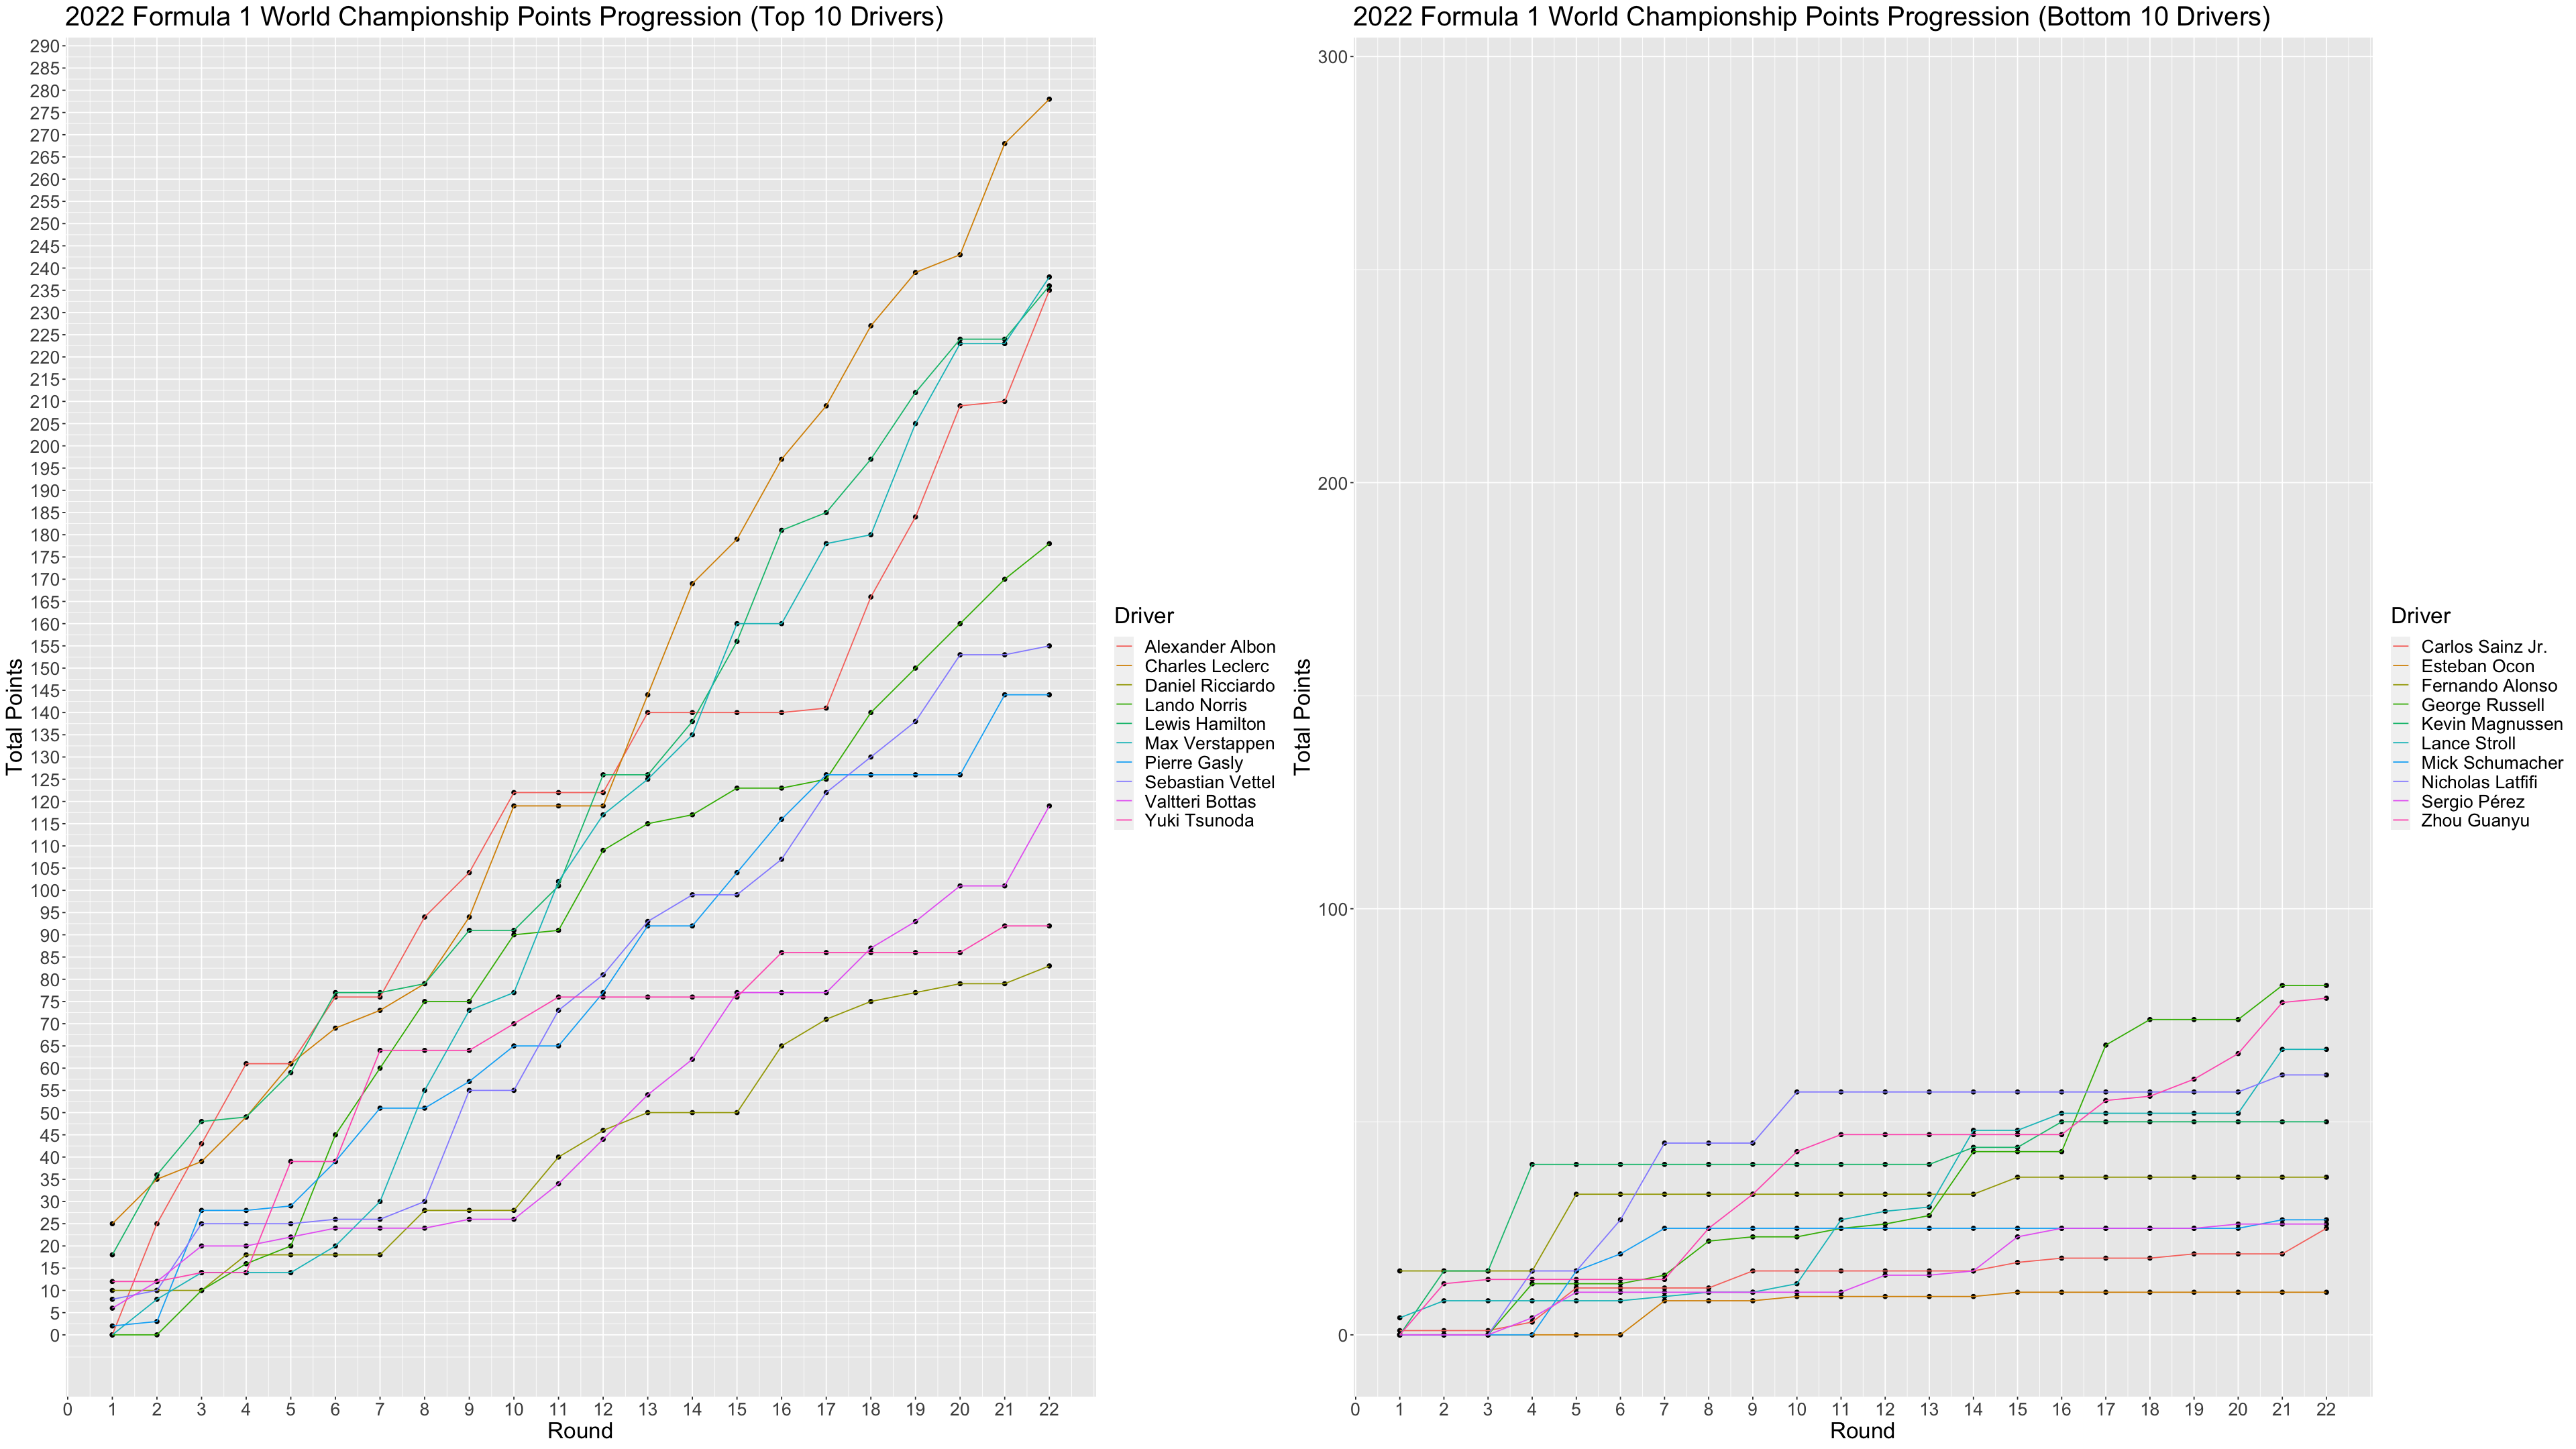

In [250]:
options(repr.plot.width = 32, repr.plot.height = 18)

#### TOP 10

driver_champ_top <- ggplot(points_top_10, aes(x = Round, y = Points_UTR)) + 
                geom_point() +
                geom_line(aes(colour = Driver)) + 
                labs(x = "Round", y = "Total Points", color = "Driver") + 
                theme(text = element_text(size = 20)) +
                ggtitle("2022 Formula 1 World Championship Points Progression (Top 10 Drivers)") + 
                scale_x_continuous(breaks = seq(0, 22, 1)) +  
                scale_y_continuous(breaks = seq(0, 300, 5)) + 
                scale_fill_brewer(palette = "Paired") 


#### BOTTOM 10


driver_champ_bottom <- ggplot(points_bottom_10, aes(x = Round, y = Points_UTR)) + 
                geom_point() +
                geom_line(aes(colour = Driver)) + 
                labs(x = "Round", y = "Total Points", color = "Driver") + 
                theme(text = element_text(size = 20)) + 
                ggtitle("2022 Formula 1 World Championship Points Progression (Bottom 10 Drivers)") + 
                scale_x_continuous(breaks = seq(0, 22, 1)) +  
                scale_fill_brewer(palette = "Paired") + 
                ylim(0, 290)


final_standings <- plot_grid(driver_champ_top, driver_champ_bottom)

final_standings

# Discussion

## Summary

We began by loading and wrangling all data into the required format. Then to predict the race time of each driver for all 22 races, we deployed linear regressions on the lap times for each driver. Computing the sum of predicted lap times enabled us to effectively simulate each race in the season. After visualizing and analyzing the standings of the constructors and drivers, we found that the top 3 teams at the end of the season were Mercedes, Ferrari, and Williams and the top 3 drivers were Charles Leclerc, Max Verstappen, and Lewis Hamilton respectively. Again, by looking at the trends of points gained by drivers, we noticed that driver performance fluctuated between races.

## Expectations

These results line up with what we expected. The top 3 teams in 2021 in real-life were Mercedes (613.5 points), Red Bull Racing (585.5 points) and Ferrari (323.5 points). In our 2022 analysis, Mercedes topped (318 points), Ferrari came second (303 points), and Williams finished third (296 points) while Charles Leclerc is the predicted world champion. The number of points awarded to all teams and drivers is much more uniform than in reality. In addition, there were some drivers and teams that were expected to have more points, like Esteban Ocon of Alpine and Carlos Sainz of Ferrari. Others such as Alexander Albon of Williams were expected to have fewer points.

In real life, the performance of a driver and team throughout the season is determined by several factors which include qualifying order, pit stops, logistics, weather, car performance and race control. Without taking into account the unpredictability of crashes and mechanical failures in addition to the many other factors, our model is more uniform than real life. However, our model appears to be relatively accurate in comparison to recent results.

## Looking Ahead

Though we had outliers, the results were primarily accurate. Mercedes and Ferrari again finished in the top 3 and so did Lewis Hamilton and Max Verstappen, possibly hinting at some form of dominance. Given that all teams in Formula 1 have different resources and driving experience, this is somewhat expected. Although dominance in sport is common, if teams like Mercedes and Ferrari and constantly finishing at the top of the table, there is a strong likelihood of the presence of gaps in structure and regulations, which is not uncommon for F1 to have to adjust to. Some of these findings could raise serious concerns regarding the integrity of the sport.

Asking if Formula 1 is being regulated in a way that gives teams certain advantages over others? Does team infrastructure influence race results? Are all teams competing on a level playing field? More importantly, if not, what changes could be made to ensure fairness in the sport?